In [356]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns

In [357]:
# import csv file raw data
raw_df = pd.read_csv('../data/okQuakes.csv')

In [358]:
raw_df.shape

(13954, 22)

In [359]:

pd.set_option('display.max_columns', None)
raw_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1973-03-17T07:43:05.500Z,36.087,-106.168,6.0,4.5,mb,NaN,NaN,NaN,NaN,us,usp00000z6,2014-11-06T23:21:10.078Z,New Mexico,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
1,1973-05-25T14:40:13.900Z,33.917,-90.775,6.0,NaN,NaN,NaN,NaN,NaN,NaN,us,usp00001xj,2014-11-06T23:21:12.859Z,Mississippi,earthquake,NaN,NaN,NaN,NaN,reviewed,s,us
2,1973-09-19T13:28:20.500Z,37.160,-104.594,5.0,NaN,NaN,NaN,NaN,NaN,NaN,us,usp00003fw,2014-11-06T23:21:20.295Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
3,1973-09-23T03:58:54.900Z,37.148,-104.571,5.0,4.2,mb,NaN,NaN,NaN,NaN,us,usp00003hd,2014-11-06T23:21:20.346Z,Colorado,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
4,1974-02-15T13:33:49.200Z,36.500,-100.693,24.0,4.5,mb,NaN,NaN,NaN,NaN,us,usp00005ac,2014-11-06T23:21:22.859Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


In [360]:
raw_df.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

Renaming columns to match column names for the other notebooks and for better understanding.

In [361]:
# Rename columns
raw_df.rename(columns = {
    
    'mag' : 'magnitude', 
    'magType' : 'mag_type', 
    'id' : 'event_id', 
    'place' : 'state', 
    }, inplace=True)
    

In [362]:
# Check data types
raw_df.dtypes

time                object
latitude           float64
longitude          float64
depth              float64
magnitude          float64
mag_type            object
nst                float64
gap                float64
dmin               float64
rms                float64
net                 object
event_id            object
updated             object
state               object
type                object
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
status              object
locationSource      object
magSource           object
dtype: object

In [363]:
# Function to fix time format and reorder columns
def Fix_time_format(raw_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function fixes the time and datetime types, adds new columns to the data frame, 
    and moves those columns to the front of the dataframe.
    Args: 
    raw_df: This is the data frame to fix the datetimes.
    Return:
    This returns the data frame with the updated datetime values, adds new columns to the data frame, 
    and moves those columns to the front of the data frame.
    """
    if 'time' not in raw_df.columns:
        raise KeyError("Input DataFrame must contain a 'time' column.")
    updated_time_df = raw_df.copy()
 
# Update columns to datetime and split into time, date, month, and year
    updated_time_df['time'] = pd.to_datetime(updated_time_df['time'])
    updated_time_df['date'] = updated_time_df['time'].dt.date
    updated_time_df['time'] = updated_time_df['time'].dt.time
    updated_time_df['date'] = pd.to_datetime(updated_time_df['date'])
    updated_time_df['month'] = updated_time_df['date'].dt.month
    updated_time_df['year'] = updated_time_df['date'].dt.year

# Move columns to the front of the column list
    column_to_move1 = updated_time_df.pop('date')
    updated_time_df.insert(1, 'date', column_to_move1)

    column_to_move2 = updated_time_df.pop('month')
    updated_time_df.insert(2, 'month', column_to_move2)

    column_to_move3 = updated_time_df.pop('year')
    updated_time_df.insert(2, 'year', column_to_move3)

    return updated_time_df

Applying function to correct datetime formats, split date to month and year, and move new columns to the front of the column list.

In [364]:
updated_time_df = Fix_time_format(raw_df)

In [365]:
updated_df = updated_time_df.copy()

In [366]:
# Correction from int32 to int64
updated_df["year"] = updated_df["year"].astype("int64")
updated_df["month"] = updated_df["month"].astype("int64")

In [367]:
updated_df.dtypes

time                       object
date               datetime64[ns]
year                        int64
month                       int64
latitude                  float64
longitude                 float64
depth                     float64
magnitude                 float64
mag_type                   object
nst                       float64
gap                       float64
dmin                      float64
rms                       float64
net                        object
event_id                   object
updated                    object
state                      object
type                       object
horizontalError           float64
depthError                float64
magError                  float64
magNst                    float64
status                     object
locationSource             object
magSource                  object
dtype: object

### Addressing large null value counts.
----
The following columns will be omitted due to not being used for analysis and/or too much missing data:


* nst - Number of Seismic Stations
* dmin - Horizontal distance from epicenter to nearest station
* net - ID of data contributor
* gap - Gap distance between stations
* rms - Root Mean Square
* horizontalError - Measure of the epicenters inaccuracy
* depthError - Uncertainty for the vertical location of epicenter
* magError - Uncertainty for the reported size of the earthquake
 * magNst - Number of stations used to calculate the magnitude of the earthquake


    

In [368]:
updated_df.copy().isnull().sum()

time                  0
date                  0
year                  0
month                 0
latitude              0
longitude             0
depth                 0
magnitude             6
mag_type             21
nst                8565
gap                1521
dmin               8333
rms                1205
net                   0
event_id              0
updated               0
state                 0
type                  0
horizontalError    3198
depthError         1810
magError           7899
magNst             7821
status                0
locationSource        0
magSource             0
dtype: int64

In [369]:
# Funtion for dropping columns from a dataframe, selected from a list

def Drop_columns(updated_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function drops unneeded columns from the data frame.
    Args: 
    updated_time_df(for this specific usage): This is the data frame to drop the columns from.
    Return:
    This returns the data frame with the unneeded columns removed.
    """
    column_list = ['nst', 'gap', 'dmin', 'rms', 'net', 'horizontalError', 'depthError',
                   'magError', 'magNst', 'locationSource', 'magSource']
    
    updated_column_df = updated_df.copy()

    for column in column_list:
        updated_column_df.drop(column, axis=1, inplace=True)

    return updated_column_df

Applying drop columns funtion

In [370]:
updated_column_df = Drop_columns(updated_df)

In [371]:
updated_column_df.isnull().sum()

time          0
date          0
year          0
month         0
latitude      0
longitude     0
depth         0
magnitude     6
mag_type     21
event_id      0
updated       0
state         0
type          0
status        0
dtype: int64

In [372]:
updated_ok_quakes_df = updated_column_df.copy()

In [373]:
# Addressing remaining missing values for Magnitude and Mag_type columns.
updated_ok_quakes_df = updated_ok_quakes_df.dropna()

In [374]:
# Confirming no null values
updated_ok_quakes_df.isnull().sum()

time         0
date         0
year         0
month        0
latitude     0
longitude    0
depth        0
magnitude    0
mag_type     0
event_id     0
updated      0
state        0
type         0
status       0
dtype: int64

In [375]:
updated_ok_quakes_df.dtypes

time                 object
date         datetime64[ns]
year                  int64
month                 int64
latitude            float64
longitude           float64
depth               float64
magnitude           float64
mag_type             object
event_id             object
updated              object
state                object
type                 object
status               object
dtype: object

In [376]:
# Assessing value counts for lacations
locations = updated_ok_quakes_df['state'].value_counts()
pd.set_option('display.max_rows', None)
locations

state
Kansas                                      1572
Oklahoma                                     740
33km NW of Fairview, Oklahoma                236
32km NW of Fairview, Oklahoma                214
Colorado                                     170
10km NE of Greenbrier, Arkansas              168
New Mexico                                   158
9km NE of Greenbrier, Arkansas               140
11km NE of Greenbrier, Arkansas              120
8km NE of Greenbrier, Arkansas               102
20km W of Perry, Oklahoma                     90
4km NE of Greenbrier, Arkansas                82
6km NE of Greenbrier, Arkansas                73
6km S of Guthrie, Oklahoma                    72
7km S of Guthrie, Oklahoma                    67
western Texas                                 64
5km NE of Greenbrier, Arkansas                64
12km SSW of Guthrie, Oklahoma                 62
3km NE of Greenbrier, Arkansas                60
northern Texas                                59
7km NE of Gree

Renaming the locations to better understand the totals for each state.

In [377]:
# Oklahoma 1
pattern_1 = '|'.join([
    "0km E of Pawnee, Oklahoma",
"0km ESE of Choctaw, Oklahoma",
"0km N of Stillwater, Oklahoma",
"0km NNW of Cherokee, Oklahoma",
"0km NNW of Stillwater, Oklahoma",
"0km NW of Pawnee, Oklahoma",
"0km SSW of Cherokee, Oklahoma",
"0km W of Pawnee, Oklahoma",
"10km E of Edmond, Oklahoma",
"10km E of Guthrie, Oklahoma",
"10km E of Helena, Oklahoma",
"10km E of Luther, Oklahoma",
"10km E of Medford, Oklahoma",
"10km ENE of Luther, Oklahoma",
"10km ENE of Mooreland, Oklahoma",
"10km ENE of Perkins, Oklahoma",
"10km ESE of Chickasha, Oklahoma",
"10km ESE of Perkins, Oklahoma",
"10km N of Edmond, Oklahoma",
"10km N of Yale, Oklahoma",
"10km NE of Cherokee, Oklahoma",
"10km NE of Chickasha, Oklahoma",
"10km NE of Crescent, Oklahoma",
"10km NE of Edmond, Oklahoma",
"10km NE of Medford, Oklahoma",
"10km NE of Stillwater, Oklahoma",
"10km NNE of Cherokee, Oklahoma",
"10km NNE of Guthrie, Oklahoma",
"10km NNE of Helena, Oklahoma",
"10km NNE of Medford, Oklahoma",
"10km NNE of Stillwater, Oklahoma",
"10km NNW of Cherokee, Oklahoma",
"10km NNW of Edmond, Oklahoma",
"10km NNW of Langston, Oklahoma",
"10km NNW of Medford, Oklahoma",
"10km NNW of Pawnee, Oklahoma",
"10km NNW of Perry, Oklahoma",
"10km NNW of Yale, Oklahoma",
"10km NW of Helena, Oklahoma",
"10km NW of Medford, Oklahoma",
"10km NW of Pawnee, Oklahoma",
"10km NW of Perkins, Oklahoma",
"10km NW of Perry, Oklahoma",
"10km NW of Prague, Oklahoma",
"10km NW of Yale, Oklahoma",
"10km S of Alva, Oklahoma",
"10km S of Boley, Oklahoma",
"10km S of Chandler, Oklahoma",
"10km S of Langston, Oklahoma",
"10km S of Perry, Oklahoma",
"10km S of Wilson, Oklahoma",
"10km SE of Cherokee, Oklahoma",
"10km SE of Medford, Oklahoma",
"10km SSE of Blanchard, Oklahoma",
"10km SSE of Cherokee, Oklahoma",
"10km SSE of Cushing, Oklahoma",
"10km SSE of Guthrie, Oklahoma",
"10km SSE of Langston, Oklahoma",
"10km SSE of Medford, Oklahoma",
"10km SSE of Pawnee, Oklahoma",
"10km SSW of Alva, Oklahoma",
"10km SSW of Chandler, Oklahoma",
"10km SSW of Langston, Oklahoma",
"10km SSW of Stillwater, Oklahoma",
"10km SSW of Tonkawa, Oklahoma",
"10km SSW of Wilson, Oklahoma",
"10km SW of Alva, Oklahoma",
"10km SW of Boley, Oklahoma",
"10km SW of Chandler, Oklahoma",
"10km SW of Pawnee, Oklahoma",
"10km SW of Watonga, Oklahoma",
"10km SW of Wilson, Oklahoma",
"10km W of Medford, Oklahoma",
"10km WNW of Blackwell, Oklahoma",
"10km WNW of Langston, Oklahoma",
"10km WNW of Yale, Oklahoma",
"10km WSW of Pawnee, Oklahoma",
"11km E of Alva, Oklahoma",
"11km E of Cherokee, Oklahoma",
"11km E of Medford, Oklahoma",
"11km E of Perkins, Oklahoma",
"11km E of Perry, Oklahoma",
"11km ENE of Luther, Oklahoma",
"11km ENE of Mooreland, Oklahoma",
"11km ESE of Langston, Oklahoma",
"11km ESE of Luther, Oklahoma",
"11km ESE of Perkins, Oklahoma",
"11km N of Cherokee, Oklahoma",
"11km N of Langston, Oklahoma",
"11km N of Perry, Oklahoma",
"11km N of Stroud, Oklahoma",
"11km N of Yale, Oklahoma",
"11km NE of Cherokee, Oklahoma",
"11km NE of Edmond, Oklahoma",
"11km NE of Luther, Oklahoma",
"11km NE of Stillwater, Oklahoma",
"11km NNE of Cherokee, Oklahoma",
"11km NNE of Guthrie, Oklahoma",
"11km NNE of Helena, Oklahoma",
"11km NNE of Luther, Oklahoma",
"11km NNE of Medford, Oklahoma",
"11km NNE of Stillwater, Oklahoma",
"11km NNW of Edmond, Oklahoma",
"11km NNW of Jones, Oklahoma",
"11km NNW of Medford, Oklahoma",
"11km NNW of Pawnee, Oklahoma",
"11km NNW of Yale, Oklahoma",
"11km NW of Helena, Oklahoma",
"11km NW of Pawnee, Oklahoma",
"11km NW of Yale, Oklahoma",
"11km S of Alva, Oklahoma",
"11km S of Langston, Oklahoma",
"11km S of Medford, Oklahoma",
"11km S of Perry, Oklahoma",
"11km SE of Cherokee, Oklahoma",
"11km SE of Medford, Oklahoma",
"11km SSE of Boley, Oklahoma",
"11km SSE of Guthrie, Oklahoma",
"11km SSW of Chandler, Oklahoma",
"11km SSW of Guthrie, Oklahoma",
"11km SSW of Tonkawa, Oklahoma",
"11km SSW of Wilson, Oklahoma",
"11km SW of Alva, Oklahoma",
"11km SW of Chandler, Oklahoma",
"11km SW of Perry, Oklahoma",
"11km W of El Reno, Oklahoma",
"11km W of Medford, Oklahoma",
"11km WNW of Helena, Oklahoma",
"11km WNW of Medford, Oklahoma",
"11km WNW of Yale, Oklahoma",
"11km WSW of Pawnee, Oklahoma",
"12km E of Luther, Oklahoma",
"12km ENE of Mooreland, Oklahoma",
"12km ESE of Alva, Oklahoma",
"12km ESE of Luther, Oklahoma",
"12km ESE of Medford, Oklahoma",
"12km ESE of Pawnee, Oklahoma",
"12km N of Cherokee, Oklahoma",
"12km N of Edmond, Oklahoma",
"12km N of Helena, Oklahoma",
"12km N of Langston, Oklahoma",
"12km N of Medford, Oklahoma",
"12km N of Perry, Oklahoma",
"12km N of Stillwater, Oklahoma",
"12km NE of Cherokee, Oklahoma",
"12km NE of Crescent, Oklahoma",
"12km NE of Edmond, Oklahoma",
"12km NE of Helena, Oklahoma",
"12km NE of Medford, Oklahoma",
"12km NNE of Edmond, Oklahoma",
"12km NNE of Luther, Oklahoma",
"12km NNE of Medford, Oklahoma",
"12km NNE of Stillwater, Oklahoma",
"12km NNW of Chandler, Oklahoma",
"12km NNW of Perry, Oklahoma",
"12km NNW of Stillwater, Oklahoma",
"12km NW of Blackwell, Oklahoma",
"12km NW of Edmond, Oklahoma",
"12km NW of Enid, Oklahoma",
"12km NW of Helena, Oklahoma",
"12km NW of Langston, Oklahoma",
"12km NW of Pawnee, Oklahoma",
"12km NW of Stillwater, Oklahoma",
"12km S of Boley, Oklahoma",
"12km S of Langston, Oklahoma",
"12km S of Perry, Oklahoma",
"12km SE of Alva, Oklahoma",
"12km SE of Helena, Oklahoma",
"12km SSE of Alva, Oklahoma",
"12km SSE of Cherokee, Oklahoma",
"12km SSE of Medford, Oklahoma",
"12km SSE of Perry, Oklahoma",
"12km SSW of Guthrie, Oklahoma",
"12km SSW of Perkins, Oklahoma",
"12km SSW of Perry, Oklahoma",
"12km SSW of Wilson, Oklahoma",
"12km SW of Cherokee, Oklahoma",
"12km SW of Medford, Oklahoma",
"12km SW of Perry, Oklahoma",
"12km W of Cherokee, Oklahoma",
"12km W of Perry, Oklahoma",
"12km W of Yale, Oklahoma",
"12km WNW of Helena, Oklahoma",
"12km WNW of Medford, Oklahoma",
"12km WNW of Pawnee, Oklahoma",
"12km WNW of Yale, Oklahoma",
"12km WSW of Cherokee, Oklahoma",
"12km WSW of Medford, Oklahoma",
"12km WSW of Pawnee, Oklahoma",
"12km WSW of Perry, Oklahoma",
"13km E of Enid, Oklahoma",
"13km E of Stillwater, Oklahoma",
"13km ENE of Mooreland, Oklahoma",
"13km ESE of Cherokee, Oklahoma",
"13km ESE of Luther, Oklahoma",
"13km ESE of Medford, Oklahoma",
"13km ESE of Pawnee, Oklahoma",
"13km N of Cherokee, Oklahoma",
"13km N of Crescent, Oklahoma",
"13km N of Edmond, Oklahoma",
"13km N of Enid, Oklahoma",
"13km NE of Cherokee, Oklahoma",
"13km NE of Crescent, Oklahoma",
"13km NE of Edmond, Oklahoma",
"13km NE of Mooreland, Oklahoma",
"13km NNE of Chandler, Oklahoma",
"13km NNE of Cherokee, Oklahoma",
"13km NNE of Crescent, Oklahoma",
"13km NNE of Edmond, Oklahoma",
"13km NNE of Helena, Oklahoma",
"13km NNE of Langston, Oklahoma",
"13km NNW of Chandler, Oklahoma",
"13km NNW of Langston, Oklahoma",
"13km NNW of Medford, Oklahoma",
"13km NNW of Pawnee, Oklahoma",
"13km NNW of Perry, Oklahoma",
"13km NNW of Stillwater, Oklahoma",
"13km NW of Blackwell, Oklahoma",
"13km NW of Chandler, Oklahoma",
"13km NW of Cushing, Oklahoma",
"13km NW of Edmond, Oklahoma",
"13km NW of Pawnee, Oklahoma",
"13km S of Boley, Oklahoma",
"13km S of Medford, Oklahoma",
"13km S of Perry, Oklahoma",
"13km SE of Langston, Oklahoma",
"13km SE of Medford, Oklahoma",
"13km SE of Pawnee, Oklahoma",
"13km SSE of Alva, Oklahoma",
"13km SSE of Langston, Oklahoma",
"13km SSE of Medford, Oklahoma",
"13km SSE of Perry, Oklahoma",
"13km SSE of Prague, Oklahoma",
"13km SSW of Guthrie, Oklahoma",
"13km SSW of McCord, Oklahoma",
"13km SSW of Perry, Oklahoma",
"13km SSW of Tonkawa, Oklahoma",
"13km SW of Cherokee, Oklahoma",
"13km SW of Perry, Oklahoma",
"13km W of Crescent, Oklahoma",
"13km W of Helena, Oklahoma",
"13km W of Medford, Oklahoma",
"13km W of Perry, Oklahoma",
"8km NNW of Langston, Oklahoma",
"6km E of McLoud, Oklahoma",
"7km N of Crescent, Oklahoma",
"8km NE of Luther, Oklahoma",
"7km NE of Harrah, Oklahoma",
"6km SSW of Alva, Oklahoma",
"9km NNW of Langston, Oklahoma",
"5km SSE of Stillwater, Oklahoma",
"9km W of Helena, Oklahoma",
"6km ENE of Luther, Oklahoma",
"7km NNW of Yale, Oklahoma",
"2km SE of Bethel Acres, Oklahoma",
"13km WNW of Alva, Oklahoma",
"7km W of Perkins, Oklahoma",
"5km SSE of Perry, Oklahoma",
"22km NW of Perry, Oklahoma",
"8km NNE of Perry, Oklahoma",
"10km ENE of Helena, Oklahoma",
"2km WSW of Perry, Oklahoma",
"1km WSW of Perry, Oklahoma",
"17km N of Crescent, Oklahoma",
"10km SSW of Perry, Oklahoma",
"11km SE of Helena, Oklahoma",
"12km ESE of Helena, Oklahoma",
"1km SSE of Cushing, Oklahoma",
"12km NW of Perry, Oklahoma",
"9km N of Guthrie, Oklahoma",
"5km SE of Enid, Oklahoma",
"21km SSE of McCord, Oklahoma",
"4km SSW of Luther, Oklahoma",
"23km ENE of Helena, Oklahoma",
"21km NNE of Cherokee, Oklahoma",
"20km NNE of Cherokee, Oklahoma",
"12km SSE of Langston, Oklahoma",
"8km WSW of Helena, Oklahoma",
"4km WNW of Prague, Oklahoma",
"4km NNE of Guthrie, Oklahoma",
"7km W of Langston, Oklahoma",
"12km NNE of Guthrie, Oklahoma",
"11km NW of Edmond, Oklahoma",
"6km W of Langston, Oklahoma",
"4km NNE of Yale, Oklahoma",
"3km ESE of Helena, Oklahoma",
"12km SW of Cushing, Oklahoma",
"9km S of Hennessey, Oklahoma",
"8km N of Meeker, Oklahoma",
"11km NW of Perry, Oklahoma",
"10km W of Luther, Oklahoma",
"0km SW of Pawnee, Oklahoma",
"1km WSW of Pawnee, Oklahoma",
"8km WSW of Langston, Oklahoma",
"9km NNW of Crescent, Oklahoma",
"6km N of Pawnee, Oklahoma",
"20km ENE of Perry, Oklahoma",
"12km NW of Cushing, Oklahoma",
"13km S of Guthrie, Oklahoma",
"12km W of Pawnee, Oklahoma",
"4km NNE of Pawnee, Oklahoma",
"25km SSE of Helena, Oklahoma",
"15km WNW of Tonkawa, Oklahoma",
"16km NE of Mooreland, Oklahoma",
"8km W of Langston, Oklahoma",
"20km WNW of Waukomis, Oklahoma",
"7km WSW of Cherokee, Oklahoma",
"21km WSW of Perry, Oklahoma",
"13km NNW of Edmond, Oklahoma",
"13km SE of Helena, Oklahoma",
"15km S of Blanchard, Oklahoma",
"24km SSW of Medford, Oklahoma",
"14km WNW of Pawnee, Oklahoma",
"18km NNW of Langston, Oklahoma",
"11km SW of Cherokee, Oklahoma",
"7km SW of Guthrie, Oklahoma",
"7km WSW of Cushing, Oklahoma",
"2km SW of Pawnee, Oklahoma",
"4km ESE of Cherokee, Oklahoma",
"11km W of Helena, Oklahoma",
"5km W of Fairview, Oklahoma",
"22km NE of Mooreland, Oklahoma",
"11km SSE of Cherokee, Oklahoma",
"13km N of Yale, Oklahoma",
"3km N of Guthrie, Oklahoma",
"12km NNW of Edmond, Oklahoma",
"10km ESE of Medford, Oklahoma",
"16km WNW of Alva, Oklahoma",
"14km E of Cherokee, Oklahoma",
"10km ESE of Waukomis, Oklahoma",
"7km SE of Helena, Oklahoma",
"22km W of Helena, Oklahoma",
"7km N of Langston, Oklahoma",
"4km WSW of Perkins, Oklahoma",
"17km SSW of Helena, Oklahoma",
"10km S of Perkins, Oklahoma",
"14km SE of Helena, Oklahoma",
"0km WNW of McLoud, Oklahoma",
"10km N of Langston, Oklahoma",
"5km ENE of Medford, Oklahoma",
"1km NNE of Cushing, Oklahoma",
"3km S of Harrah, Oklahoma",
"23km NE of Enid, Oklahoma",
"1km NNE of Crescent, Oklahoma",
"10km E of Alva, Oklahoma",
"6km SSW of Boley, Oklahoma",
"4km SW of Stillwater, Oklahoma",
"1km SSE of Medford, Oklahoma",
"18km E of Duncan, Oklahoma",
"0km NNW of McLoud, Oklahoma",
"5km NNE of Cherokee, Oklahoma",
"14km ENE of Cherokee, Oklahoma",
"6km SW of Pawnee, Oklahoma",
"20km E of Enid, Oklahoma",
"1km NE of Pawnee, Oklahoma",
"0km N of Pawnee, Oklahoma",
"2km WNW of McLoud, Oklahoma",
"2km N of Cushing, Oklahoma",
"10km WNW of Medford, Oklahoma",
"15km W of Blackwell, Oklahoma",
"3km ENE of Harrah, Oklahoma",
"4km NE of Pawnee, Oklahoma",
"16km S of Blanchard, Oklahoma",
"7km NNE of Pawnee, Oklahoma",
"29km SSE of Alva, Oklahoma",
"16km NE of Enid, Oklahoma",
"15km SW of Helena, Oklahoma",
"12km S of Alva, Oklahoma",
"6km WNW of Perkins, Oklahoma",
"7km SE of Medford, Oklahoma",
"1km W of Pawnee, Oklahoma",
"5km NNE of Crescent, Oklahoma",
"18km NNE of Fairview, Oklahoma",
"14km SSE of Alva, Oklahoma",
"23km WSW of Helena, Oklahoma",
"13km ENE of Cherokee, Oklahoma",
"11km ESE of Alva, Oklahoma",
"16km WSW of Cherokee, Oklahoma",
"12km WNW of Healdton, Oklahoma",
"10km NNW of Healdton, Oklahoma",
"8km NW of Healdton, Oklahoma",
"3km SE of Fairview, Oklahoma",
"13km SE of Guthrie, Oklahoma",
"12km NW of Yale, Oklahoma",
"10km ENE of Medford, Oklahoma",
"15km SE of Medford, Oklahoma",
"19km WNW of Waukomis, Oklahoma",
"8km WSW of Yukon, Oklahoma",
"5km WSW of Cushing, Oklahoma",
"2km SSW of Crescent, Oklahoma",
"1km WNW of McLoud, Oklahoma",
"12km SSW of Boley, Oklahoma",
"5km NNW of Edmond, Oklahoma",
"26km E of Mooreland, Oklahoma",
"12km N of Seminole, Oklahoma",
"26km W of Helena, Oklahoma",
"8km NE of Skiatook, Oklahoma",
"16km SE of Tonkawa, Oklahoma",
"22km NE of Enid, Oklahoma",
"9km S of Chandler, Oklahoma",
"15km WNW of Alva, Oklahoma",
"20km W of Blackwell, Oklahoma",
"10km WNW of Perkins, Oklahoma",
"11km WNW of Blackwell, Oklahoma",
"1km SSE of Perry, Oklahoma",
"16km ENE of Enid, Oklahoma",
"1km SE of Perry, Oklahoma",
"4km WNW of Langston, Oklahoma",
"12km NW of Fairview, Oklahoma",
"1km SE of Edmond, Oklahoma",
"5km NNE of Perkins, Oklahoma",
"25km E of Mooreland, Oklahoma",
"4km NW of Cushing, Oklahoma",
"24km E of Mooreland, Oklahoma",
"9km WNW of Cherokee, Oklahoma",
"17km SSW of McCord, Oklahoma",
"9km NW of Langston, Oklahoma",
"20km SW of Perry, Oklahoma",
"7km SSE of Perry, Oklahoma",
"7km WSW of Yale, Oklahoma",
"3km W of Fairview, Oklahoma",
"21km NNE of Okeene, Oklahoma",
"32km ENE of Mooreland, Oklahoma",
"1km SW of Cherokee, Oklahoma",
"33km ENE of Mooreland, Oklahoma",
"7km SE of Edmond, Oklahoma",
"19km W of Helena, Oklahoma",
"1km ENE of Pawnee, Oklahoma",
"11km SSW of Okarche, Oklahoma",
"1km NNW of Cushing, Oklahoma",
"23km WNW of Waukomis, Oklahoma",
"5km WNW of Cushing, Oklahoma",
"24km NE of Perry, Oklahoma",
"11km SSE of Cushing, Oklahoma",
"18km NE of Fairview, Oklahoma",
"3km SSE of Harrah, Oklahoma",
"3km ESE of Pawnee, Oklahoma",
"6km NNW of Stroud, Oklahoma",
"23km NE of Taloga, Oklahoma",
"12km SSW of McCord, Oklahoma",
"2km NNW of Guthrie, Oklahoma",
"1km N of Cushing, Oklahoma",
"1km NW of Cushing, Oklahoma",
"2km ENE of Pawnee, Oklahoma",
"20km W of Helena, Oklahoma",
"17km S of Helena, Oklahoma",
"2km WSW of Stillwater, Oklahoma",
"28km NW of Fairview, Oklahoma",
"15km SW of Cushing, Oklahoma",
"5km W of Cushing, Oklahoma",
"14km NE of Mooreland, Oklahoma",
"16km E of Enid, Oklahoma",
"10km SSW of Cushing, Oklahoma",
"14km SW of Tonkawa, Oklahoma",
"16km ESE of Enid, Oklahoma",
"2km SSE of Alva, Oklahoma",
"4km SW of Medford, Oklahoma",
"15km NNW of Luther, Oklahoma",
"25km WNW of Fairview, Oklahoma",
"10km WSW of Stillwater, Oklahoma",
"10km ESE of Alva, Oklahoma",
"3km SSE of Langston, Oklahoma",
"10km E of Perry, Oklahoma",
"31km NW of Alva, Oklahoma",
"9km SSW of Okarche, Oklahoma",
"16km NE of Kingfisher, Oklahoma",
"1km SW of Choctaw, Oklahoma",
"15km NNE of Helena, Oklahoma",
"10km S of Mooreland, Oklahoma",
"16km WNW of Blackwell, Oklahoma",
"13km W of Pawnee, Oklahoma",
"16km SSW of Alva, Oklahoma",
"1km SW of Alva, Oklahoma",
"14km NW of Cushing, Oklahoma",
"14km SSE of Helena, Oklahoma",
"21km NW of Pawnee, Oklahoma",
"16km SE of Perkins, Oklahoma",
"2km SSE of Cherokee, Oklahoma",
"26km NE of Mooreland, Oklahoma",
"15km NNW of Crescent, Oklahoma",
"15km ENE of Rush Springs, Oklahoma",
"14km S of Blanchard, Oklahoma",
"12km S of Blanchard, Oklahoma",
"18km S of Helena, Oklahoma",
"11km WSW of Perry, Oklahoma",
"21km NNE of Perry, Oklahoma",
"9km SW of Perry, Oklahoma",
"12km NNE of Crescent, Oklahoma",
"14km SW of Watonga, Oklahoma",
"15km WSW of Cherokee, Oklahoma",
"15km SSW of Alva, Oklahoma",
"5km NNW of Medford, Oklahoma",
"1km NE of Stillwater, Oklahoma",
"20km ENE of Helena, Oklahoma",
"4km SW of Cherokee, Oklahoma",
"21km ENE of Helena, Oklahoma",
"13km E of Rush Springs, Oklahoma",
"14km W of Perry, Oklahoma",
"14km N of Chandler, Oklahoma",
"30km NW of Fairview, Oklahoma",
"20km NNE of Perry, Oklahoma",
"4km ENE of Langston, Oklahoma",
"7km SW of Helena, Oklahoma",
"24km NNW of Enid, Oklahoma",
"9km N of Medford, Oklahoma",
"29km NW of Fairview, Oklahoma",
"12km N of Enid, Oklahoma",
"7km ESE of Crescent, Oklahoma",
"25km SW of Medford, Oklahoma",
"11km NW of Oologah, Oklahoma",
"5km SW of Medford, Oklahoma",
"12km ENE of Helena, Oklahoma",
"10km WNW of Helena, Oklahoma",
"16km NNW of Edmond, Oklahoma",
"7km SW of Medford, Oklahoma",
"20km NNE of Okeene, Oklahoma",
"17km N of Fairview, Oklahoma",
"4km SSE of Chandler, Oklahoma",
"2km E of Stroud, Oklahoma",
"23km NNE of Woodward, Oklahoma",

    ])

In [378]:
# Oklahoma 2
pattern_2 = '|'.join(["13km WNW of Cherokee, Oklahoma",
"13km WNW of Helena, Oklahoma",
"13km WNW of Medford, Oklahoma",
"13km WNW of Pawnee, Oklahoma",
"13km WNW of Yale, Oklahoma",
"13km WSW of Cherokee, Oklahoma",
"13km WSW of Helena, Oklahoma",
"13km WSW of Pawnee, Oklahoma",
"13km WSW of Stillwater, Oklahoma",
"14km E of Enid, Oklahoma",
"14km E of Perry, Oklahoma",
"14km ENE of Enid, Oklahoma",
"14km ENE of Mooreland, Oklahoma",
"14km ENE of Rush Springs, Oklahoma",
"14km ESE of Cherokee, Oklahoma",
"14km ESE of Luther, Oklahoma",
"14km ESE of Medford, Oklahoma",
"14km ESE of Pawnee, Oklahoma",
"14km N of Crescent, Oklahoma",
"14km N of Enid, Oklahoma",
"14km N of Langston, Oklahoma",
"14km N of Perry, Oklahoma",
"14km NE of Cherokee, Oklahoma",
"14km NE of Edmond, Oklahoma",
"14km NE of Enid, Oklahoma",
"14km NE of Perry, Oklahoma",
"14km NNE of Chandler, Oklahoma",
"14km NNE of Crescent, Oklahoma",
"14km NNE of Helena, Oklahoma",
"14km NNE of Langston, Oklahoma",
"14km NNE of Stillwater, Oklahoma",
"14km NNW of Blackwell, Oklahoma",
"14km NNW of Langston, Oklahoma",
"14km NNW of Pawnee, Oklahoma",
"14km NNW of Perry, Oklahoma",
"14km NW of Blackwell, Oklahoma",
"14km NW of Chandler, Oklahoma",
"14km NW of Pawnee, Oklahoma",
"14km S of Langston, Oklahoma",
"14km S of McCord, Oklahoma",
"14km S of Medford, Oklahoma",
"14km SE of Bray, Oklahoma",
"14km SE of Cherokee, Oklahoma",
"14km SE of Guthrie, Oklahoma",
"14km SE of Medford, Oklahoma",
"14km SSE of Guthrie, Oklahoma",
"14km SSE of Medford, Oklahoma",
"14km SSE of Mooreland, Oklahoma",
"14km SSW of Medford, Oklahoma",
"14km SSW of Perry, Oklahoma",
"14km SSW of Tonkawa, Oklahoma",
"14km SW of Cherokee, Oklahoma",
"14km SW of Coalgate, Oklahoma",
"14km SW of Hartshorne, Oklahoma",
"14km SW of Helena, Oklahoma",
"14km SW of Medford, Oklahoma",
"14km SW of Pawnee, Oklahoma",
"14km SW of Perry, Oklahoma",
"14km W of Helena, Oklahoma",
"14km W of Pawnee, Oklahoma",
"14km W of Yale, Oklahoma",
"14km WNW of Cherokee, Oklahoma",
"14km WNW of Helena, Oklahoma",
"14km WNW of Medford, Oklahoma",
"14km WNW of Yale, Oklahoma",
"14km WSW of Pawnee, Oklahoma",
"14km WSW of Stillwater, Oklahoma",
"15km E of Cherokee, Oklahoma",
"15km E of Helena, Oklahoma",
"15km E of Perry, Oklahoma",
"15km E of Stillwater, Oklahoma",
"15km ENE of Cherokee, Oklahoma",
"15km ENE of Enid, Oklahoma",
"15km ENE of Mooreland, Oklahoma",
"15km ENE of Stillwater, Oklahoma",
"15km ESE of Cherokee, Oklahoma",
"15km ESE of Enid, Oklahoma",
"15km ESE of Medford, Oklahoma",
"15km ESE of Pawnee, Oklahoma",
"15km N of Enid, Oklahoma",
"15km N of Stillwater, Oklahoma",
"15km NE of Cherokee, Oklahoma",
"15km NE of Crescent, Oklahoma",
"15km NE of Edmond, Oklahoma",
"15km NE of Enid, Oklahoma",
"15km NE of Helena, Oklahoma",
"15km NNE of Chandler, Oklahoma",
"15km NNE of Cherokee, Oklahoma",
"15km NNE of Crescent, Oklahoma",
"15km NNE of Enid, Oklahoma",
"15km NNE of Fairview, Oklahoma",
"15km NNE of Stillwater, Oklahoma",
"15km NNW of Langston, Oklahoma",
"15km NNW of Medford, Oklahoma",
"15km NNW of Pawnee, Oklahoma",
"15km NNW of Perry, Oklahoma",
"15km NW of Langston, Oklahoma",
"15km NW of Pawnee, Oklahoma",
"15km S of Langston, Oklahoma",
"15km S of McCord, Oklahoma",
"15km S of Medford, Oklahoma",
"15km S of Perry, Oklahoma",
"15km SE of Bray, Oklahoma",
"15km SE of Cherokee, Oklahoma",
"15km SSE of Medford, Oklahoma",
"15km SSW of Boley, Oklahoma",
"15km SSW of Cherokee, Oklahoma",
"15km SSW of Perry, Oklahoma",
"15km SW of Cherokee, Oklahoma",
"15km SW of Medford, Oklahoma",
"15km SW of Perry, Oklahoma",
"15km SW of Tonkawa, Oklahoma",
"15km W of Pawnee, Oklahoma",
"15km W of Perry, Oklahoma",
"15km W of Stillwater, Oklahoma",
"15km WNW of Chandler, Oklahoma",
"15km WNW of Helena, Oklahoma",
"15km WNW of Medford, Oklahoma",
"15km WNW of Pawnee, Oklahoma",
"15km WNW of Yale, Oklahoma",
"15km WSW of Guthrie, Oklahoma",
"15km WSW of Medford, Oklahoma",
"15km WSW of Pawnee, Oklahoma",
"15km WSW of Perry, Oklahoma",
"15km WSW of Stillwater, Oklahoma",
"16km E of Cherokee, Oklahoma",
"16km E of Helena, Oklahoma",
"16km E of Medford, Oklahoma",
"16km E of Waukomis, Oklahoma",
"16km ENE of Cherokee, Oklahoma",
"16km ENE of Mooreland, Oklahoma",
"16km ENE of Perry, Oklahoma",
"16km ENE of Stillwater, Oklahoma",
"16km ESE of Cherokee, Oklahoma",
"16km ESE of Medford, Oklahoma",
"16km N of Enid, Oklahoma",
"16km N of Stillwater, Oklahoma",
"16km NE of Cherokee, Oklahoma",
"16km NE of Edmond, Oklahoma",
"16km NE of Perry, Oklahoma",
"16km NNE of Cherokee, Oklahoma",
"16km NNE of Luther, Oklahoma",
"16km NNW of Crescent, Oklahoma",
"16km NNW of Langston, Oklahoma",
"16km NNW of Medford, Oklahoma",
"16km NNW of Perry, Oklahoma",
"16km NW of Langston, Oklahoma",
"16km NW of Medford, Oklahoma",
"16km S of Medford, Oklahoma",
"16km S of Perry, Oklahoma",
"16km SSE of Helena, Oklahoma",
"16km SSE of Medford, Oklahoma",
"16km SSW of Boley, Oklahoma",
"16km SSW of Medford, Oklahoma",
"16km SSW of Perkins, Oklahoma",
"16km SW of Medford, Oklahoma",
"16km SW of Perry, Oklahoma",
"16km SW of Tonkawa, Oklahoma",
"16km W of Enid, Oklahoma",
"16km W of Helena, Oklahoma",
"16km W of Pawnee, Oklahoma",
"16km W of Perry, Oklahoma",
"16km W of Stillwater, Oklahoma",
"16km WNW of Enid, Oklahoma",
"16km WNW of Helena, Oklahoma",
"16km WNW of Medford, Oklahoma",
"16km WNW of Pawnee, Oklahoma",
"16km WNW of Perry, Oklahoma",
"16km WSW of Medford, Oklahoma",
"16km WSW of Pawnee, Oklahoma",
"16km WSW of Perry, Oklahoma",
"17km ESE of Sulphur, Oklahoma",
"14km WSW of Cherokee, Oklahoma",
"9km NE of Pawnee, Oklahoma",
"12km NNE of Langston, Oklahoma",
"22km SSE of Tonkawa, Oklahoma",
"5km E of Edmond, Oklahoma",
"5km NNE of Edmond, Oklahoma",
"4km N of Cherokee, Oklahoma",
"16km ENE of Helena, Oklahoma",
"4km WSW of Hartshorne, Oklahoma",
"4km E of Harrah, Oklahoma",
"23km W of Waukomis, Oklahoma",
"9km W of Yale, Oklahoma",
"9km NW of Medford, Oklahoma",
"8km WSW of Waukomis, Oklahoma",
"8km WNW of Yale, Oklahoma",
"6km SE of Crescent, Oklahoma",
"4km SSE of Perkins, Oklahoma",
"6km E of Fairview, Oklahoma",
"5km WNW of Prague, Oklahoma",
"13km W of Yale, Oklahoma",
"24km WSW of Medford, Oklahoma",
"10km ENE of Edmond, Oklahoma",
"4km WSW of Luther, Oklahoma",
"17km NE of Taloga, Oklahoma",
"19km NE of Mooreland, Oklahoma",
"8km ESE of Guthrie, Oklahoma",
"11km SSW of Perry, Oklahoma",
"4km SW of Luther, Oklahoma",
"12km N of Guthrie, Oklahoma",
"26km WNW of McAlester, Oklahoma",
"1km ESE of Hennessey, Oklahoma",
"14km ESE of Enid, Oklahoma",
"6km WSW of Meeker, Oklahoma",
"23km SSW of Mooreland, Oklahoma",
"23km NW of Taloga, Oklahoma",
"24km S of Mooreland, Oklahoma",
"28km S of Alva, Oklahoma",
"11km NNE of Fairview, Oklahoma",
"9km ENE of Medford, Oklahoma",
"32km SSW of Alva, Oklahoma",
"26km WNW of Perry, Oklahoma",
"10km NNE of Luther, Oklahoma",
"35km E of Mooreland, Oklahoma",
"6km S of Cherokee, Oklahoma",
"27km W of Helena, Oklahoma",
"3km NW of Fairview, Oklahoma",
"4km NW of Fairview, Oklahoma",
"11km ESE of Cherokee, Oklahoma",
"5km SE of Cushing, Oklahoma",
"7km NNE of Perkins, Oklahoma",
"19km N of Vian, Oklahoma",
"9km NW of Perry, Oklahoma",
"9km NNE of Helena, Oklahoma",
"22km NW of Pawnee, Oklahoma",
"10km ENE of Perry, Oklahoma",
"16km SE of Helena, Oklahoma",
"2km SW of Jones, Oklahoma",
"2km ENE of Tuttle, Oklahoma",
"12km SE of Tonkawa, Oklahoma",
"4km SW of Yale, Oklahoma",
"13km S of Alva, Oklahoma",
"14km S of Alva, Oklahoma",
"9km N of Luther, Oklahoma",
"0km NNE of Cushing, Oklahoma",
"11km NE of Harrah, Oklahoma",
"12km WNW of Laverne, Oklahoma",
"1km N of Stillwater, Oklahoma",
"9km NNE of Cherokee, Oklahoma",
"17km ESE of Enid, Oklahoma",
"2Oklahoma",
"12km S of Perkins, Oklahoma",
"5km WNW of Jones, Oklahoma",
"12km SW of Goldsby, Oklahoma",
"12km SE of Blanchard, Oklahoma",
"16km NW of Chandler, Oklahoma",
"25km ESE of Enid, Oklahoma",
"10km SSE of Alva, Oklahoma",
"6km E of Guthrie, Oklahoma",
"9km SW of Goldsby, Oklahoma",
"13km SSW of Alva, Oklahoma",
"25km SW of Alva, Oklahoma",
"20km SSE of Wetumka, Oklahoma",
"22km ENE of Watonga, Oklahoma",
"4km NNE of Cherokee, Oklahoma",
"2km ENE of Luther, Oklahoma",
"9km NNW of Coalgate, Oklahoma",
"9km N of Thomas, Oklahoma",
"8km SW of Yale, Oklahoma",
"4km N of Choctaw, Oklahoma",
"20km N of Enid, Oklahoma",
"9km SSE of Cherokee, Oklahoma",
"26km WSW of Fairview, Oklahoma",
"16km SSW of Cherokee, Oklahoma",
"12km SSW of Alva, Oklahoma",
"11km SSW of Alva, Oklahoma",
"21km SSE of Tonkawa, Oklahoma",
"2km N of Pawnee, Oklahoma",
"17km SW of Alva, Oklahoma",
"7km WSW of Meeker, Oklahoma",
"10km N of Crescent, Oklahoma",
"22km SSE of Helena, Oklahoma",
"13km ESE of Chickasha, Oklahoma",
"12km ENE of Ninnekah, Oklahoma",
"1km N of Pawnee, Oklahoma",
"5km NNW of Yale, Oklahoma",
"28km SW of Tonkawa, Oklahoma",
"3km WSW of Stillwater, Oklahoma",
"10km WSW of Cushing, Oklahoma",
"4km SW of Perry, Oklahoma",
"2km E of Guthrie, Oklahoma",
"7km W of Buffalo, Oklahoma",
"9km SW of Stillwater, Oklahoma",
"7km W of Meeker, Oklahoma",
"5km SE of Mooreland, Oklahoma",
"2km NE of Langston, Oklahoma",
"7km ENE of Guthrie, Oklahoma",
"4km E of Perry, Oklahoma",
"6km S of Crescent, Oklahoma",
"21km NE of Helena, Oklahoma",
"5km SE of Chickasha, Oklahoma",
"5km ESE of Fairview, Oklahoma",
"6km ESE of Chickasha, Oklahoma",
"16km NW of Pawnee, Oklahoma",
"8km N of Pawnee, Oklahoma",
"7km N of Pawnee, Oklahoma",
"20km WNW of Pawnee, Oklahoma",
"9km NNW of Perry, Oklahoma",
"8km SSE of El Reno, Oklahoma",
"26km NNE of Mooreland, Oklahoma",
"7km NNW of Coalgate, Oklahoma",
"11km NNE of Crescent, Oklahoma",
"5km N of Pawnee, Oklahoma",
"1km NE of Cushing, Oklahoma",
"24km W of Helena, Oklahoma",
"9km SE of Blanchard, Oklahoma",
"19km NE of Taloga, Oklahoma",
"25km NNE of Mooreland, Oklahoma",
"9km ESE of Alva, Oklahoma",
"0km WSW of Spencer, Oklahoma",
"5km SSW of Cherokee, Oklahoma",
"4km WSW of Yale, Oklahoma",
"13km SW of Perkins, Oklahoma",
"11km WNW of Pawnee, Oklahoma"
])

In [379]:
# Oklahoma 3
pattern_3 = '|'.join(["17km E of Medford, Oklahoma",
"17km E of Waukomis, Oklahoma",
"17km ENE of Cherokee, Oklahoma",
"17km ENE of Mooreland, Oklahoma",
"17km ENE of Perry, Oklahoma",
"17km ENE of Stillwater, Oklahoma",
"17km ESE of Medford, Oklahoma",
"17km N of Stillwater, Oklahoma",
"17km NE of Cherokee, Oklahoma",
"17km NE of Crescent, Oklahoma",
"17km NE of Fairview, Oklahoma",
"17km NE of Helena, Oklahoma",
"17km NE of Perry, Oklahoma",
"17km NE of Seminole, Oklahoma",
"17km NNE of Crescent, Oklahoma",
"17km NNE of Enid, Oklahoma",
"17km NNE of Helena, Oklahoma",
"17km NNE of Stillwater, Oklahoma",
"17km NNW of Medford, Oklahoma",
"17km NW of Alva, Oklahoma",
"17km NW of Medford, Oklahoma",
"17km S of Blanchard, Oklahoma",
"17km S of McCord, Oklahoma",
"17km S of Medford, Oklahoma",
"17km S of Perry, Oklahoma",
"17km SE of Helena, Oklahoma",
"17km SE of Medford, Oklahoma",
"17km SE of Tonkawa, Oklahoma",
"17km SSE of Bray, Oklahoma",
"17km SSE of Medford, Oklahoma",
"17km SSE of Wetumka, Oklahoma",
"17km SSW of Alva, Oklahoma",
"17km SSW of Medford, Oklahoma",
"17km SW of Medford, Oklahoma",
"17km SW of Perry, Oklahoma",
"17km W of Helena, Oklahoma",
"17km W of Pawnee, Oklahoma",
"17km W of Perry, Oklahoma",
"17km W of Stillwater, Oklahoma",
"17km WNW of Marietta, Oklahoma",
"17km WNW of Medford, Oklahoma",
"17km WSW of Medford, Oklahoma",
"18km E of Cherokee, Oklahoma",
"18km E of Waukomis, Oklahoma",
"18km ENE of Cherokee, Oklahoma",
"18km ENE of Helena, Oklahoma",
"18km ENE of Mooreland, Oklahoma",
"18km ENE of Perry, Oklahoma",
"18km ESE of Cherokee, Oklahoma",
"18km ESE of Medford, Oklahoma",
"18km N of Crescent, Oklahoma",
"18km N of Perry, Oklahoma",
"18km NE of Cherokee, Oklahoma",
"18km NE of Crescent, Oklahoma",
"18km NE of Enid, Oklahoma",
"18km NE of Helena, Oklahoma",
"18km NE of Taloga, Oklahoma",
"18km NNE of Cherokee, Oklahoma",
"18km NNE of Crescent, Oklahoma",
"18km NNE of Enid, Oklahoma",
"18km NNW of Crescent, Oklahoma",
"18km NNW of Medford, Oklahoma",
"18km NW of Blackwell, Oklahoma",
"18km NW of Langston, Oklahoma",
"18km NW of Medford, Oklahoma",
"18km NW of Pawnee, Oklahoma",
"18km S of Medford, Oklahoma",
"18km S of Perry, Oklahoma",
"18km S of Tonkawa, Oklahoma",
"18km SE of Helena, Oklahoma",
"18km SE of Medford, Oklahoma",
"18km SE of Tonkawa, Oklahoma",
"18km SSE of Medford, Oklahoma",
"18km SSE of Tonkawa, Oklahoma",
"18km SSE of Wetumka, Oklahoma",
"18km SSW of McCord, Oklahoma",
"18km SSW of Medford, Oklahoma",
"18km W of Helena, Oklahoma",
"18km W of Perry, Oklahoma",
"18km W of Stillwater, Oklahoma",
"18km WNW of Helena, Oklahoma",
"18km WSW of Medford, Oklahoma",
"18km WSW of Perry, Oklahoma",
"19km E of Hennessey, Oklahoma",
"19km E of Waukomis, Oklahoma",
"19km ENE of Cherokee, Oklahoma",
"19km ENE of Mooreland, Oklahoma",
"19km ENE of Perry, Oklahoma",
"19km ESE of Cherokee, Oklahoma",
"19km ESE of Enid, Oklahoma",
"19km N of Crescent, Oklahoma",
"19km N of Enid, Oklahoma",
"19km N of Perry, Oklahoma",
"19km N of Stillwater, Oklahoma",
"19km NE of Cherokee, Oklahoma",
"19km NE of Crescent, Oklahoma",
"19km NNE of Cherokee, Oklahoma",
"19km NNE of Crescent, Oklahoma",
"19km NNE of Enid, Oklahoma",
"19km NNW of Crescent, Oklahoma",
"19km NNW of Langston, Oklahoma",
"19km NNW of Medford, Oklahoma",
"19km NW of Medford, Oklahoma",
"19km S of Medford, Oklahoma",
"19km S of Perry, Oklahoma",
"19km S of Tonkawa, Oklahoma",
"19km SE of Helena, Oklahoma",
"19km SSE of Medford, Oklahoma",
"19km SSE of Tonkawa, Oklahoma",
"19km SW of Medford, Oklahoma",
"19km W of Pawnee, Oklahoma",
"19km W of Perry, Oklahoma",
"19km WNW of Pawnee, Oklahoma",
"19km WSW of Helena, Oklahoma",
"19km WSW of Medford, Oklahoma",
"1km E of Choctaw, Oklahoma",
"1km E of Jones, Oklahoma",
"1km E of Luther, Oklahoma",
"1km ENE of Cushing, Oklahoma",
"1km ENE of Nicoma Park, Oklahoma",
"1km ENE of Perry, Oklahoma",
"1km ENE of Stillwater, Oklahoma",
"1km ESE of Choctaw, Oklahoma",
"1km ESE of Luther, Oklahoma",
"1km ESE of Pawnee, Oklahoma",
"1km ESE of Perry, Oklahoma",
"1km ESE of Stillwater, Oklahoma",
"1km N of Jones, Oklahoma",
"1km NE of Choctaw, Oklahoma",
"1km NE of Jones, Oklahoma",
"1km NE of Medford, Oklahoma",
"1km NNE of Jones, Oklahoma",
"1km NNE of Medford, Oklahoma",
"1km NNE of Pawnee, Oklahoma",
"1km NNW of Stillwater, Oklahoma",
"1km NW of Medford, Oklahoma",
"1km NW of Minco, Oklahoma",
"1km NW of Stillwater, Oklahoma",
"1km S of Cherokee, Oklahoma",
"1km S of Choctaw, Oklahoma",
"1km SE of Cherokee, Oklahoma",
"1km SE of Choctaw, Oklahoma",
"1km SE of Pawnee, Oklahoma",
"1km SE of Stillwater, Oklahoma",
"1km SSE of Choctaw, Oklahoma",
"1km SSE of Stillwater, Oklahoma",
"1km SSW of Cherokee, Oklahoma",
"1km SSW of Choctaw, Oklahoma",
"1km W of Cushing, Oklahoma",
"1km W of Jones, Oklahoma",
"1km WNW of Cushing, Oklahoma",
"1km WNW of Medford, Oklahoma",
"1km WSW of Stillwater, Oklahoma",
"6km N of Harrah, Oklahoma",
"2km NE of Jones, Oklahoma",
"8km W of Luther, Oklahoma",
"6km E of Jones, Oklahoma",
"2km NNW of McLoud, Oklahoma",
"7km ESE of Boley, Oklahoma",
"9km ENE of McLoud, Oklahoma",
"5km NNE of Jones, Oklahoma",
"7km W of Cushing, Oklahoma",
"2km E of Harrah, Oklahoma",
"11km SSE of Tishomingo, Oklahoma",
"5km ESE of McLoud, Oklahoma",
"15km ENE of Kingston, Oklahoma",
"6km WNW of Spencer, Oklahoma",
"28km ENE of Helena, Oklahoma",
"3km WNW of Boley, Oklahoma",
"4km NE of Jones, Oklahoma",
"7km E of Meeker, Oklahoma",
"26km NE of Enid, Oklahoma",
"19km NE of Enid, Oklahoma",
"9km E of Madill, Oklahoma",
"10km SW of Tuttle, Oklahoma",
"9km SW of Coalgate, Oklahoma",
"8km NNE of McLoud, Oklahoma",
"4km NNW of McLoud, Oklahoma",
"3km NNW of McLoud, Oklahoma",
"4km N of Luther, Oklahoma",
"3km N of Luther, Oklahoma",
"9km E of Jones, Oklahoma",
"11km SSE of Medford, Oklahoma",
"0km NNW of Jones, Oklahoma",
"16km NE of Seminole, Oklahoma",
"4km NE of Harrah, Oklahoma",
"4km N of Medford, Oklahoma",
"1km WNW of Jones, Oklahoma",
"7km NNE of Chickasha, Oklahoma",
"7km WSW of Tonkawa, Oklahoma",
"25km S of Medford, Oklahoma",
"4km WNW of Marietta, Oklahoma",
"4km W of Marietta, Oklahoma",
"2km NNE of Marietta, Oklahoma",
"6km NW of Marietta, Oklahoma",
"2km NW of Marietta, Oklahoma",
"9km WNW of Marietta, Oklahoma",
"10km SSW of Boley, Oklahoma",
"8km W of Oakland, Oklahoma",
"0km NE of Jones, Oklahoma",
"16km NE of Kingston, Oklahoma",
"0km N of Prague, Oklahoma",
"13km NW of Yale, Oklahoma",
"1km WNW of Spencer, Oklahoma",
"2km NNW of Prague, Oklahoma",
"8km WNW of Jones, Oklahoma",
"8km NW of Jones, Oklahoma",
"19km SSW of Medford, Oklahoma",
"12km NE of Stillwater, Oklahoma",
"12km ENE of Chickasha, Oklahoma",
"11km SSE of Prague, Oklahoma",
"4km N of Edmond, Oklahoma",
"31km NNW of Broken Bow, Oklahoma",
"7km SSE of Luther, Oklahoma",
"1km N of Luther, Oklahoma",
"9km SE of Edmond, Oklahoma",
"6km SSE of Luther, Oklahoma",
"3km N of Choctaw, Oklahoma",
"6km NW of Perkins, Oklahoma",
"14km E of Stillwater, Oklahoma",
"8km SE of Alva, Oklahoma",
"22km S of McCord, Oklahoma",
"8km SSW of Fairview, Oklahoma",
"1km NNW of Nicoma Park, Oklahoma",
"6km S of Purcell, Oklahoma",
"10km SSE of Prague, Oklahoma",
"11km N of Edmond, Oklahoma",
"10km NNW of Prague, Oklahoma",
"11km SSW of Cushing, Oklahoma",
"22km NW of Coalgate, Oklahoma",
"7km ENE of Stillwater, Oklahoma",
"14km NNW of Chandler, Oklahoma",
"9km N of Cherokee, Oklahoma",
"15km SSE of Wetumka, Oklahoma",
"3km NNW of Perkins, Oklahoma",
"2km ESE of Stillwater, Oklahoma",
"3km SW of Alva, Oklahoma",
"7km SE of Luther, Oklahoma",
"6km N of Medford, Oklahoma",
"10km NE of Langston, Oklahoma",
"5km E of Cherokee, Oklahoma",
"3km NNW of Medford, Oklahoma",
"2km WSW of Nicoma Park, Oklahoma",
"13km WSW of Perry, Oklahoma",
"23km NNW of Enid, Oklahoma",
"2km SW of Boley, Oklahoma",
"11km WNW of El Reno, Oklahoma",
"5km NNE of Spencer, Oklahoma",
"3km WSW of Alva, Oklahoma",
"31km WSW of McAlester, Oklahoma",
"2km NNE of Stroud, Oklahoma",
"12km E of Medford, Oklahoma",
"12km S of Medford, Oklahoma",
"2km W of Spencer, Oklahoma",
"14km ESE of Stillwater, Oklahoma",
"2km NE of Nicoma Park, Oklahoma",
"24km SSW of Tecumseh, Oklahoma",
"3km NE of Cherokee, Oklahoma",
"10km E of Perkins, Oklahoma",
"2km SSE of Choctaw, Oklahoma",
"2km WSW of Pawnee, Oklahoma",
"1km NE of Nicoma Park, Oklahoma",
"8km S of Pawnee, Oklahoma",
"6km SW of Alva, Oklahoma",
"11km W of Pawnee, Oklahoma",
"3km WSW of Guthrie, Oklahoma",
"1km SE of Langston, Oklahoma",
"1km WSW of Medford, Oklahoma",
"14km WNW of Cushing, Oklahoma",
"11km ENE of Medford, Oklahoma",
"20km NNW of Crescent, Oklahoma",
"5km E of Jones, Oklahoma",
"8km ENE of Medford, Oklahoma",
"6km ESE of Meeker, Oklahoma",
"8km SSW of Boley, Oklahoma",
"7km WSW of Alva, Oklahoma",
"6km SSW of Medford, Oklahoma",
"6km S of Medford, Oklahoma",
"7km NNE of Helena, Oklahoma",
"9km WNW of Yale, Oklahoma",
"6km SW of Cushing, Oklahoma",
"9km NNE of Perry, Oklahoma",
"8km NNE of Pawnee, Oklahoma",
"9km NNW of Edmond, Oklahoma",
"8km E of Medford, Oklahoma",
"7km E of Perkins, Oklahoma",
"9km SE of Medford, Oklahoma",
"7km WNW of Cherokee, Oklahoma",
"7km NE of Mooreland, Oklahoma",
"7km NNW of Luther, Oklahoma",
"7km N of Guthrie, Oklahoma",
"9km S of Alva, Oklahoma",
"6km E of Meeker, Oklahoma",
"6km NNE of Helena, Oklahoma",
"9km N of Madill, Oklahoma",

])

In [380]:
# Oklahoma 4
pattern_4 = '|'.join([
    "20km E of Cherokee, Oklahoma",
"20km ENE of Cherokee, Oklahoma",
"20km ENE of Mooreland, Oklahoma",
"20km ESE of Enid, Oklahoma",
"20km N of Crescent, Oklahoma",
"20km N of Perry, Oklahoma",
"20km NE of Cherokee, Oklahoma",
"20km NE of Crescent, Oklahoma",
"20km NE of Enid, Oklahoma",
"20km NE of Helena, Oklahoma",
"20km NNE of Crescent, Oklahoma",
"20km NNE of Enid, Oklahoma",
"20km NNW of Langston, Oklahoma",
"20km NNW of Medford, Oklahoma",
"20km NW of Medford, Oklahoma",
"20km S of McCord, Oklahoma",
"20km S of Medford, Oklahoma",
"20km SSE of Medford, Oklahoma",
"20km SSE of Tonkawa, Oklahoma",
"20km SSW of Medford, Oklahoma",
"20km SW of Medford, Oklahoma",
"20km W of Pawnee, Oklahoma",
"20km W of Perry, Oklahoma",
"20km WNW of Perry, Oklahoma",
"20km WSW of Medford, Oklahoma",
"20km WSW of Perry, Oklahoma",
"21km E of Cherokee, Oklahoma",
"21km E of Waukomis, Oklahoma",
"21km ENE of Cherokee, Oklahoma",
"21km ENE of Mooreland, Oklahoma",
"21km ENE of Perry, Oklahoma",
"21km ESE of Cherokee, Oklahoma",
"21km N of Crescent, Oklahoma",
"21km N of Enid, Oklahoma",
"21km NE of Cherokee, Oklahoma",
"21km NE of Crescent, Oklahoma",
"21km NE of Perry, Oklahoma",
"21km NE of Taloga, Oklahoma",
"21km NNE of Enid, Oklahoma",
"21km NNW of Medford, Oklahoma",
"21km NW of Fairview, Oklahoma",
"21km NW of Langston, Oklahoma",
"21km NW of Medford, Oklahoma",
"21km S of Medford, Oklahoma",
"21km SE of Medford, Oklahoma",
"21km SSE of Medford, Oklahoma",
"21km SSW of McCord, Oklahoma",
"21km SSW of Medford, Oklahoma",
"21km SW of Medford, Oklahoma",
"21km SW of Perry, Oklahoma",
"21km W of Perry, Oklahoma",
"21km WNW of Pawnee, Oklahoma",
"21km WNW of Perry, Oklahoma",
"21km WSW of Helena, Oklahoma",
"21km WSW of Medford, Oklahoma",
"22km E of Cherokee, Oklahoma",
"22km E of Fairview, Oklahoma",
"22km E of Mooreland, Oklahoma",
"22km E of Waukomis, Oklahoma",
"22km ENE of Cherokee, Oklahoma",
"22km ENE of Helena, Oklahoma",
"22km ENE of Mooreland, Oklahoma",
"22km ENE of Perry, Oklahoma",
"22km ESE of Cherokee, Oklahoma",
"22km ESE of Waukomis, Oklahoma",
"22km N of Enid, Oklahoma",
"22km NE of Cherokee, Oklahoma",
"22km NE of Crescent, Oklahoma",
"22km NE of Perry, Oklahoma",
"22km NE of Taloga, Oklahoma",
"22km NNE of Cherokee, Oklahoma",
"22km NNE of Crescent, Oklahoma",
"22km NNE of Enid, Oklahoma",
"22km NNE of Okeene, Oklahoma",
"22km NNE of Perry, Oklahoma",
"22km NW of Healdton, Oklahoma",
"22km NW of Langston, Oklahoma",
"22km NW of Medford, Oklahoma",
"22km S of Alva, Oklahoma",
"22km S of Medford, Oklahoma",
"22km SSE of Medford, Oklahoma",
"22km SSW of McCord, Oklahoma",
"22km SSW of Medford, Oklahoma",
"22km SSW of Perry, Oklahoma",
"22km SW of Medford, Oklahoma",
"22km SW of Perry, Oklahoma",
"22km W of Medford, Oklahoma",
"22km W of Perry, Oklahoma",
"22km WNW of Medford, Oklahoma",
"22km WNW of Pawnee, Oklahoma",
"22km WNW of Perry, Oklahoma",
"22km WSW of Helena, Oklahoma",
"22km WSW of Perry, Oklahoma",
"23km E of Cherokee, Oklahoma",
"23km E of Waukomis, Oklahoma",
"23km ENE of Cherokee, Oklahoma",
"23km ENE of Mooreland, Oklahoma",
"23km ESE of Waukomis, Oklahoma",
"23km N of Enid, Oklahoma",
"23km N of Fairview, Oklahoma",
"23km NE of Cherokee, Oklahoma",
"23km NE of Perry, Oklahoma",
"23km NNE of Enid, Oklahoma",
"23km NNE of Okeene, Oklahoma",
"23km NNE of Perry, Oklahoma",
"23km S of Alva, Oklahoma",
"23km S of McCord, Oklahoma",
"23km S of Medford, Oklahoma",
"23km SSE of Lindsay, Oklahoma",
"23km SSE of Medford, Oklahoma",
"23km SSW of Medford, Oklahoma",
"23km SW of Perry, Oklahoma",
"23km W of Medford, Oklahoma",
"23km W of Perry, Oklahoma",
"23km WNW of Medford, Oklahoma",
"23km WNW of Pawnee, Oklahoma",
"23km WSW of Medford, Oklahoma",
"23km WSW of Perry, Oklahoma",
"24km E of Cherokee, Oklahoma",
"24km ENE of Cherokee, Oklahoma",
"24km ENE of Helena, Oklahoma",
"24km ENE of Mooreland, Oklahoma",
"24km N of Enid, Oklahoma",
"24km NE of Cherokee, Oklahoma",
"24km NNW of Healdton, Oklahoma",
"24km S of Lindsay, Oklahoma",
"24km SSE of Medford, Oklahoma",
"24km SSW of Alva, Oklahoma",
"24km SW of Cherokee, Oklahoma",
"24km SW of Medford, Oklahoma",
"24km W of Medford, Oklahoma",
"24km W of Perry, Oklahoma",
"24km W of Waukomis, Oklahoma",
"24km WNW of Fairview, Oklahoma",
"24km WNW of Medford, Oklahoma",
"24km WNW of Pawnee, Oklahoma",
"24km WSW of Perry, Oklahoma",
"24km WSW of Tonkawa, Oklahoma",
"25km E of Cherokee, Oklahoma",
"25km ENE of Cherokee, Oklahoma",
"25km ENE of Helena, Oklahoma",
"25km ENE of Mooreland, Oklahoma",
"25km NE of Cherokee, Oklahoma",
"25km NE of Helena, Oklahoma",
"25km NE of Mooreland, Oklahoma",
"25km NE of Perry, Oklahoma",
"25km NW of Healdton, Oklahoma",
"25km S of Alva, Oklahoma",
"25km S of McCord, Oklahoma",
"25km S of Mooreland, Oklahoma",
"25km SSE of Medford, Oklahoma",
"25km W of Helena, Oklahoma",
"25km W of Medford, Oklahoma",
"25km W of Perry, Oklahoma",
"25km WNW of Medford, Oklahoma",
"25km WNW of Pawnee, Oklahoma",
"25km WSW of Medford, Oklahoma",
"25km WSW of Perry, Oklahoma",
"26km E of Cherokee, Oklahoma",
"26km E of Waukomis, Oklahoma",
"26km ENE of Helena, Oklahoma",
"26km NE of Helena, Oklahoma",
"26km NE of Perry, Oklahoma",
"26km NNW of Healdton, Oklahoma",
"26km NW of Fairview, Oklahoma",
"26km SSE of Medford, Oklahoma",
"26km SW of Medford, Oklahoma",
"26km W of Medford, Oklahoma",
"26km W of Perry, Oklahoma",
"26km WNW of Medford, Oklahoma",
"26km WSW of Medford, Oklahoma",
"26km WSW of Perry, Oklahoma",
"27km E of Cherokee, Oklahoma",
"27km E of Waukomis, Oklahoma",
"27km NE of Helena, Oklahoma",
"27km NNW of Enid, Oklahoma",
"27km NW of Fairview, Oklahoma",
"27km S of Alva, Oklahoma",
"27km SSE of Medford, Oklahoma",
"27km SSW of Maysville, Oklahoma",
"27km SW of Medford, Oklahoma",
"27km SW of Tonkawa, Oklahoma",
"27km W of Medford, Oklahoma",
"27km WNW of Medford, Oklahoma",
"27km WSW of Medford, Oklahoma",
"27km WSW of Perry, Oklahoma",
"27km WSW of Tonkawa, Oklahoma",
"28km E of Cherokee, Oklahoma",
"28km ENE of Mooreland, Oklahoma",
"28km NE of Helena, Oklahoma",
"28km W of Helena, Oklahoma",
"29km NNW of Fairview, Oklahoma",
"29km S of Alva, Oklahoma",
"29km W of Helena, Oklahoma",
"7km N of Spencer, Oklahoma",
"8km N of Spencer, Oklahoma",
"7km NNE of Luther, Oklahoma",
"7km SSW of Guthrie, Oklahoma",
"7km E of Edmond, Oklahoma",
"8km NNE of Edmond, Oklahoma",
"1Oklahoma",
"9km NE of Cherokee, Oklahoma",
"7km WSW of Langston, Oklahoma",
"8km SE of Edmond, Oklahoma",
"6km SSW of Guthrie, Oklahoma",
"8km NNW of Spencer, Oklahoma",
"8km NW of Perkins, Oklahoma",
"8km E of Edmond, Oklahoma",
"6km NE of Langston, Oklahoma",
"7km ESE of Guthrie, Oklahoma",
"6km WSW of Langston, Oklahoma",
"9km NW of Prague, Oklahoma",
"9km NNW of Blackwell, Oklahoma",
"9km NNW of Pawnee, Oklahoma",
"9km E of Guthrie, Oklahoma",
"8km ENE of Guthrie, Oklahoma",
"7km NW of Perkins, Oklahoma",
"6km E of Edmond, Oklahoma",
"9km ESE of Guthrie, Oklahoma",
"9km E of Medford, Oklahoma",
"6km N of Cherokee, Oklahoma",
"9km N of Spencer, Oklahoma",
"7km ENE of Harrah, Oklahoma",
"8km NNE of Luther, Oklahoma",
"9km ENE of Cherokee, Oklahoma",
"7km SW of Pawnee, Oklahoma",
"6km SSW of Luther, Oklahoma",
"7km N of Jones, Oklahoma",
"7km NNW of Spencer, Oklahoma",
"6km NW of Medford, Oklahoma",
"9km NW of Perkins, Oklahoma",
"7km ENE of Hennessey, Oklahoma",
"9km SSE of Blanchard, Oklahoma",
"6km ESE of Guthrie, Oklahoma",
"8km ENE of Luther, Oklahoma",
"8km NW of Prague, Oklahoma",
"7km E of Guthrie, Oklahoma",
"8km ENE of Perry, Oklahoma",
"9km ENE of Luther, Oklahoma",
"9km ENE of Enid, Oklahoma",
"8km ENE of Cherokee, Oklahoma",
"9km E of Edmond, Oklahoma",
"9km NNW of Yale, Oklahoma",
"9km NW of Pawnee, Oklahoma",
"6km SW of Boley, Oklahoma",
"6km NNE of Edmond, Oklahoma",
"7km NNE of Edmond, Oklahoma",
"9km SW of Pawnee, Oklahoma",
"9km SSE of Pawnee, Oklahoma",
"9km NNW of Medford, Oklahoma",
"6km NNE of Luther, Oklahoma",
"8km NE of Cherokee, Oklahoma",
"6km SW of Guthrie, Oklahoma",
"8km SSW of Guthrie, Oklahoma",
"7km E of McLoud, Oklahoma",
"9km SSW of Tonkawa, Oklahoma",
"7km WNW of Perkins, Oklahoma",
"8km NE of Guthrie, Oklahoma",
"8km SSE of Helena, Oklahoma",
"6km WSW of Pawnee, Oklahoma",
"7km NW of Pawnee, Oklahoma",
"9km SE of Enid, Oklahoma",
"8km SE of Blanchard, Oklahoma",
"6km NW of Yale, Oklahoma",
"6km N of Luther, Oklahoma",
"8km E of Guthrie, Oklahoma",
"9km ENE of Stillwater, Oklahoma",
"8km ENE of Stillwater, Oklahoma",
"8km NW of Langston, Oklahoma",
"8km SW of Alva, Oklahoma",
"6km E of Medford, Oklahoma",
"7km WSW of Pawnee, Oklahoma",
"7km NNW of Perkins, Oklahoma",
"6km N of Spencer, Oklahoma",
"8km NE of Pawnee, Oklahoma",
"9km NNE of Edmond, Oklahoma",
"6km NNW of Yale, Oklahoma",
"8km SE of Helena, Oklahoma",
"7km NE of Helena, Oklahoma",
"8km W of Meeker, Oklahoma",
"9km SSE of Langston, Oklahoma",
"8km WNW of Perkins, Oklahoma",
"9km SE of Luther, Oklahoma",
"9km WSW of Cherokee, Oklahoma",
"9km ENE of Perry, Oklahoma",
"9km S of Boley, Oklahoma",
"8km ENE of McLoud, Oklahoma",
"8km WSW of Pawnee, Oklahoma",
"6km NE of Choctaw, Oklahoma",
"8km WSW of Cherokee, Oklahoma",
"2Oklahoma",
"8km NNE of Harrah, Oklahoma",
"6km NE of Cherokee, Oklahoma",
"7km NW of Langston, Oklahoma",
"7km SSW of Boley, Oklahoma",
"9km WNW of Prague, Oklahoma",
"6km ENE of McLoud, Oklahoma",
"9km SW of Alva, Oklahoma",
"6km NE of Harrah, Oklahoma",
"8km ENE of Enid, Oklahoma",
"8km NW of Yale, Oklahoma",
"6km NNW of Langston, Oklahoma",
"8km NNW of Pawnee, Oklahoma",
"17km NW of Pawnee, Oklahoma",
"7km ESE of Chickasha, Oklahoma",
"24km NNW of Fairview, Oklahoma",
"25km NNW of Fairview, Oklahoma",
"9km NNW of Maysville, Oklahoma",
"6km NW of Jones, Oklahoma",
"6km WNW of Jones, Oklahoma",
"4km NNE of Midwest City, Oklahoma",
"9km SSW of Boley, Oklahoma",
"8km E of Meeker, Oklahoma",
"2km WSW of Jones, Oklahoma",
"6km SSE of Tishomingo, Oklahoma",
"3km SSW of Nicoma Park, Oklahoma",
"3km SE of Choctaw, Oklahoma",
"12km ENE of Luther, Oklahoma",
"6km WSW of Chandler, Oklahoma",
"20km W of McAlester, Oklahoma",
"2km WSW of Luther, Oklahoma",
"5km SSW of Luther, Oklahoma",
"18km NE of Seminole, Oklahoma",
"1km N of Midwest City, Oklahoma",
"13km ENE of Dickson, Oklahoma",
"5km NE of Luther, Oklahoma",
"6km NE of Jones, Oklahoma",
"7km NW of Prague, Oklahoma",
"12km N of Luther, Oklahoma",
"18km NE of Luther, Oklahoma",
"13km ENE of Luther, Oklahoma",
"7km NE of Luther, Oklahoma",
"5km ENE of Luther, Oklahoma",
"10km ESE of Luther, Oklahoma",

])

In [381]:
# Oklahoma 5
pattern_5 = '|'.join(["2km E of Choctaw, Oklahoma",
"2km E of Luther, Oklahoma",
"2km E of Perry, Oklahoma",
"2km ENE of Choctaw, Oklahoma",
"2km ENE of Medford, Oklahoma",
"2km ENE of Stillwater, Oklahoma",
"2km ESE of Choctaw, Oklahoma",
"2km ESE of Harrah, Oklahoma",
"2km ESE of Pawnee, Oklahoma",
"2km ESE of Perry, Oklahoma",
"2km NE of Luther, Oklahoma",
"2km NE of Medford, Oklahoma",
"2km NNE of Medford, Oklahoma",
"2km NW of Minco, Oklahoma",
"2km S of Perry, Oklahoma",
"2km SE of Cherokee, Oklahoma",
"2km SE of Choctaw, Oklahoma",
"2km SE of Pawnee, Oklahoma",
"2km SE of Perry, Oklahoma",
"2km SSE of Cushing, Oklahoma",
"2km SSE of Pawnee, Oklahoma",
"2km SSE of Perry, Oklahoma",
"2km SSE of Stillwater, Oklahoma",
"2km SSW of Perry, Oklahoma",
"2km SSW of Stillwater, Oklahoma",
"2km SW of Medford, Oklahoma",
"2km SW of Stillwater, Oklahoma",
"2km W of Cushing, Oklahoma",
"2km WNW of Cushing, Oklahoma",
"2km WNW of Medford, Oklahoma",
"2km WNW of Stillwater, Oklahoma",
"2km WSW of Cushing, Oklahoma",
"2km WSW of Medford, Oklahoma",
"2km WSW of Spencer, Oklahoma",
"30km NNW of Fairview, Oklahoma",
"30km S of Alva, Oklahoma",
"31km E of Mooreland, Oklahoma",
"31km NW of Fairview, Oklahoma",
"31km S of Alva, Oklahoma",
"32km E of Mooreland, Oklahoma",
"32km NW of Fairview, Oklahoma",
"32km S of Alva, Oklahoma",
"33km E of Mooreland, Oklahoma",
"33km NW of Fairview, Oklahoma",
"33km S of Alva, Oklahoma",
"33km WNW of Fairview, Oklahoma",
"34km E of Mooreland, Oklahoma",
"34km NW of Fairview, Oklahoma",
"34km S of Alva, Oklahoma",
"35km NW of Fairview, Oklahoma",
"36km E of Mooreland, Oklahoma",
"3km E of Choctaw, Oklahoma",
"3km E of Luther, Oklahoma",
"3km E of Stillwater, Oklahoma",
"3km ENE of Choctaw, Oklahoma",
"3km ENE of Guthrie, Oklahoma",
"3km ENE of Medford, Oklahoma",
"3km ENE of Pawnee, Oklahoma",
"3km ENE of Stillwater, Oklahoma",
"3km ESE of Luther, Oklahoma",
"3km ESE of Perry, Oklahoma",
"3km N of Harrah, Oklahoma",
"3km NNE of Edmond, Oklahoma",
"3km NNE of Guthrie, Oklahoma",
"3km NNE of Harrah, Oklahoma",
"3km NNE of Medford, Oklahoma",
"3km NNE of Yale, Oklahoma",
"3km NW of Cushing, Oklahoma",
"3km NW of Jones, Oklahoma",
"3km NW of Medford, Oklahoma",
"3km NW of Perkins, Oklahoma",
"3km S of Cushing, Oklahoma",
"3km S of Langston, Oklahoma",
"3km S of Perry, Oklahoma",
"3km SE of Cherokee, Oklahoma",
"3km SE of Pawnee, Oklahoma",
"3km SE of Perry, Oklahoma",
"3km SE of Stillwater, Oklahoma",
"3km SSE of Alva, Oklahoma",
"3km SSE of Jones, Oklahoma",
"3km SSE of Pawnee, Oklahoma",
"3km SSE of Perry, Oklahoma",
"3km SSE of Stillwater, Oklahoma",
"3km SSW of Cushing, Oklahoma",
"3km SSW of Perry, Oklahoma",
"3km SSW of Stillwater, Oklahoma",
"3km SW of Cushing, Oklahoma",
"3km SW of Jones, Oklahoma",
"3km SW of Medford, Oklahoma",
"3km SW of Stillwater, Oklahoma",
"3km W of Boley, Oklahoma",
"3km W of Cushing, Oklahoma",
"3km W of Jones, Oklahoma",
"3km W of Langston, Oklahoma",
"3km WNW of Choctaw, Oklahoma",
"3km WNW of Cushing, Oklahoma",
"3km WNW of Stillwater, Oklahoma",
"3km WSW of Boley, Oklahoma",
"3km WSW of Cushing, Oklahoma",
"3km WSW of Medford, Oklahoma",
"3km WSW of Nicoma Park, Oklahoma",
"3km WSW of Pawnee, Oklahoma",
"4km E of Edmond, Oklahoma",
"4km E of Langston, Oklahoma",
"4km E of Luther, Oklahoma",
"4km ENE of Crescent, Oklahoma",
"4km ENE of Edmond, Oklahoma",
"4km ENE of Harrah, Oklahoma",
"4km ENE of Medford, Oklahoma",
"4km ESE of Edmond, Oklahoma",
"4km ESE of Fairview, Oklahoma",
"4km ESE of Harrah, Oklahoma",
"4km ESE of Helena, Oklahoma",
"4km ESE of Jones, Oklahoma",
"4km ESE of Medford, Oklahoma",
"4km ESE of Pawnee, Oklahoma",
"4km ESE of Perry, Oklahoma",
"4km N of Helena, Oklahoma",
"4km N of Perkins, Oklahoma",
"4km NE of Crescent, Oklahoma",
"4km NE of Langston, Oklahoma",
"4km NE of Medford, Oklahoma",
"4km NNE of Crescent, Oklahoma",
"4km NNE of Edmond, Oklahoma",
"4km NNE of Helena, Oklahoma",
"4km NNE of Jones, Oklahoma",
"4km NNE of Stillwater, Oklahoma",
"4km NNW of Cherokee, Oklahoma",
"4km NNW of Helena, Oklahoma",
"4km NNW of Medford, Oklahoma",
"4km NNW of Pawnee, Oklahoma",
"4km NW of Jones, Oklahoma",
"4km NW of Medford, Oklahoma",
"4km NW of Perkins, Oklahoma",
"4km S of Cushing, Oklahoma",
"4km S of Langston, Oklahoma",
"4km S of Perry, Oklahoma",
"4km S of Stillwater, Oklahoma",
"4km SE of Cherokee, Oklahoma",
"4km SE of Jones, Oklahoma",
"4km SE of Pawnee, Oklahoma",
"4km SE of Perry, Oklahoma",
"4km SE of Stillwater, Oklahoma",
"4km SSE of Pawnee, Oklahoma",
"4km SSE of Perry, Oklahoma",
"4km SSW of Alva, Oklahoma",
"4km SSW of Cushing, Oklahoma",
"4km SSW of Langston, Oklahoma",
"4km SSW of Pawnee, Oklahoma",
"4km SW of Guthrie, Oklahoma",
"4km W of Cherokee, Oklahoma",
"4km W of Cushing, Oklahoma",
"4km W of Fairview, Oklahoma",
"4km W of Jones, Oklahoma",
"4km W of Langston, Oklahoma",
"4km WNW of Medford, Oklahoma",
"4km WNW of Stillwater, Oklahoma",
"4km WSW of Boley, Oklahoma",
"4km WSW of Cushing, Oklahoma",
"4km WSW of Guthrie, Oklahoma",
"4km WSW of Meeker, Oklahoma",
"5km E of Luther, Oklahoma",
"5km E of Perkins, Oklahoma",
"5km E of Stillwater, Oklahoma",
"5km E of Waukomis, Oklahoma",
"5km ENE of Crescent, Oklahoma",
"5km ENE of Edmond, Oklahoma",
"5km ENE of McLoud, Oklahoma",
"5km ESE of Cherokee, Oklahoma",
"5km ESE of Edmond, Oklahoma",
"5km ESE of Helena, Oklahoma",
"5km ESE of Mooreland, Oklahoma",
"5km ESE of Owasso, Oklahoma",
"5km ESE of Pawnee, Oklahoma",
"5km ESE of Perry, Oklahoma",
"5km ESE of Stillwater, Oklahoma",
"5km ESE of Tonkawa, Oklahoma",
"5km N of Cherokee, Oklahoma",
"5km N of Perkins, Oklahoma",
"5km N of Stillwater, Oklahoma",
"5km N of Yale, Oklahoma",
"5km NE of Choctaw, Oklahoma",
"5km NE of Crescent, Oklahoma",
"5km NE of Edmond, Oklahoma",
"5km NE of Medford, Oklahoma",
"5km NE of Stillwater, Oklahoma",
"5km NNE of Choctaw, Oklahoma",
"5km NNE of Guthrie, Oklahoma",
"5km NNE of Langston, Oklahoma",
"5km NNE of Medford, Oklahoma",
"5km NNE of Stillwater, Oklahoma",
"5km NNE of Union City, Oklahoma",
"5km NNE of Yale, Oklahoma",
"5km NNW of Cushing, Oklahoma",
"5km NNW of Guthrie, Oklahoma",
"5km NNW of Helena, Oklahoma",
"5km NW of Helena, Oklahoma",
"5km NW of Yale, Oklahoma",
"5km S of Cushing, Oklahoma",
"5km S of Guthrie, Oklahoma",
"5km S of Langston, Oklahoma",
"5km S of Pawnee, Oklahoma",
"5km S of Stillwater, Oklahoma",
"5km SE of Cherokee, Oklahoma",
"5km SE of Fairview, Oklahoma",
"5km SE of Guthrie, Oklahoma",
"5km SE of Pawnee, Oklahoma",
"5km SE of Perry, Oklahoma",
"5km SE of Stillwater, Oklahoma",
"5km SSE of Cushing, Oklahoma",
"5km SSE of Guthrie, Oklahoma",
"5km SSW of Cushing, Oklahoma",
"5km SSW of Langston, Oklahoma",
"5km SSW of Pawnee, Oklahoma",
"5km SSW of Perry, Oklahoma",
"5km SW of Cherokee, Oklahoma",
"5km SW of Langston, Oklahoma",
"5km SW of Perkins, Oklahoma",
"5km W of Cherokee, Oklahoma",
"5km W of Medford, Oklahoma",
"5km W of Pawnee, Oklahoma",
"5km WNW of Helena, Oklahoma",
"5km WNW of Langston, Oklahoma",
"5km WNW of Medford, Oklahoma",
"5km WSW of Guthrie, Oklahoma",
"5km WSW of Medford, Oklahoma",
"5km WSW of Perry, Oklahoma",
"6km E of Luther, Oklahoma",
"6km E of Perry, Oklahoma",
"6km E of Stillwater, Oklahoma",
"6km ENE of Edmond, Oklahoma",
"6km ENE of Langston, Oklahoma",
"6km ESE of Cherokee, Oklahoma",
"6km ESE of Edmond, Oklahoma",
"6km ESE of Helena, Oklahoma",
"6km ESE of Medford, Oklahoma",
"6km ESE of Pawnee, Oklahoma",
"6km ESE of Perry, Oklahoma",
"6km ESE of Stillwater, Oklahoma",
"6km N of Cushing, Oklahoma",
"6km N of Helena, Oklahoma",
"6km N of Perry, Oklahoma",
"6km N of Stillwater, Oklahoma",
"6km N of Yale, Oklahoma",
"6km NE of Crescent, Oklahoma",
"6km NE of Edmond, Oklahoma",
"6km NE of Medford, Oklahoma",
"6km NE of Stillwater, Oklahoma",
"6km NNE of Crescent, Oklahoma",
"6km NNE of Guthrie, Oklahoma",
"6km NNE of Langston, Oklahoma",
"6km NNE of Medford, Oklahoma",
"6km NNE of Stillwater, Oklahoma",
"6km NNE of Union City, Oklahoma",
"6km NNW of Cushing, Oklahoma",
"6km NNW of Guthrie, Oklahoma",
"6km NNW of Helena, Oklahoma",
"6km NW of Helena, Oklahoma",
"6km NW of Stillwater, Oklahoma",
"6km S of Cushing, Oklahoma",
"6km S of Guthrie, Oklahoma",
"6km S of Langston, Oklahoma",
"6km S of Perry, Oklahoma",
"6km S of Stillwater, Oklahoma",
"6km SE of Cherokee, Oklahoma",
"6km SE of Fairview, Oklahoma",
"6km SE of Guthrie, Oklahoma",
"6km SE of Pawnee, Oklahoma",
"6km SE of Perry, Oklahoma",
"6km SE of Stillwater, Oklahoma",
"6km SSE of Cushing, Oklahoma",
"6km SSE of Guthrie, Oklahoma",
"6km SSW of Cushing, Oklahoma",
"6km SSW of Langston, Oklahoma",
"6km SSW of Pawnee, Oklahoma",
"6km SSW of Perry, Oklahoma",
"6km SW of Cherokee, Oklahoma",
"6km SW of Langston, Oklahoma",
"6km SW of Perkins, Oklahoma",
"6km W of Cherokee, Oklahoma",
"6km W of Medford, Oklahoma",
"6km W of Pawnee, Oklahoma",
"6km WNW of Helena, Oklahoma",
"6km WNW of Langston, Oklahoma",
"6km WNW of Medford, Oklahoma",
"6km WSW of Guthrie, Oklahoma",
"6km WSW of Medford, Oklahoma",
"6km WSW of Perry, Oklahoma",
"7km E of Luther, Oklahoma",
"7km E of Perry, Oklahoma",
"7km ENE of Crescent, Oklahoma",
"7km ENE of Edmond, Oklahoma",
"7km ENE of Langston, Oklahoma",
"7km ESE of Cherokee, Oklahoma",
"7km ESE of Edmond, Oklahoma",
"7km ESE of Helena, Oklahoma",
"7km ESE of Medford, Oklahoma",
"7km ESE of Pawnee, Oklahoma",
"7km ESE of Perry, Oklahoma",
"7km ESE of Stillwater, Oklahoma",
"7km N of Cushing, Oklahoma",
"7km N of Helena, Oklahoma",
"7km N of Perry, Oklahoma",
"7km N of Stillwater, Oklahoma",
"7km N of Yale, Oklahoma",
"7km NE of Crescent, Oklahoma",
"7km NE of Edmond, Oklahoma",
"7km NE of Medford, Oklahoma",
"7km NE of Stillwater, Oklahoma",
"7km NNE of Crescent, Oklahoma",
"7km NNE of Guthrie, Oklahoma",
"7km NNE of Langston, Oklahoma",
"7km NNE of Medford, Oklahoma",
"7km NNE of Stillwater, Oklahoma",
"7km NNE of Union City, Oklahoma",
"7km NNW of Cushing, Oklahoma",
"7km NNW of Guthrie, Oklahoma",
"7km NNW of Helena, Oklahoma",
"7km NW of Helena, Oklahoma",
"7km NW of Stillwater, Oklahoma",
"7km S of Cushing, Oklahoma",
"7km S of Guthrie, Oklahoma",
"7km S of Langston, Oklahoma",
"7km S of Perry, Oklahoma",
"7km S of Stillwater, Oklahoma",
"7km SE of Cherokee, Oklahoma",
"7km SE of Fairview, Oklahoma",
"7km SE of Guthrie, Oklahoma",
"7km SE of Pawnee, Oklahoma",
"7km SE of Perry, Oklahoma",
"7km SE of Stillwater, Oklahoma",
"7km SSE of Cushing, Oklahoma",
"7km SSE of Guthrie, Oklahoma",
"7km SSW of Cushing, Oklahoma",
"7km SSW of Langston, Oklahoma",
"7km SSW of Pawnee, Oklahoma",
"7km SSW of Perry, Oklahoma",
"7km SW of Cherokee, Oklahoma",
"7km SW of Langston, Oklahoma",
"7km SW of Perkins, Oklahoma",
"7km W of Cherokee, Oklahoma",
"7km W of Medford, Oklahoma",
"7km W of Pawnee, Oklahoma",
"7km WNW of Helena, Oklahoma",
"7km WNW of Langston, Oklahoma",
"7km WNW of Medford, Oklahoma",
"7km WSW of Guthrie, Oklahoma",
"7km WSW of Medford, Oklahoma",
"7km WSW of Perry, Oklahoma",
"8km E of Luther, Oklahoma",
"8km E of Perry, Oklahoma",
"8km ENE of Crescent, Oklahoma",
"8km ENE of Edmond, Oklahoma",
"8km ENE of Langston, Oklahoma",
"8km ESE of Cherokee, Oklahoma",
"8km ESE of Edmond, Oklahoma",
"8km ESE of Helena, Oklahoma",
"8km ESE of Medford, Oklahoma",
"8km ESE of Pawnee, Oklahoma",
"8km ESE of Perry, Oklahoma",
"8km ESE of Stillwater, Oklahoma",
"8km N of Cushing, Oklahoma",
"8km N of Helena, Oklahoma",
"8km N of Perry, Oklahoma",
"8km N of Stillwater, Oklahoma",
"8km N of Yale, Oklahoma",
"8km NE of Crescent, Oklahoma",
"8km NE of Edmond, Oklahoma",
"8km NE of Medford, Oklahoma",
"8km NE of Stillwater, Oklahoma",
"8km NNE of Crescent, Oklahoma",
"8km NNE of Guthrie, Oklahoma",
"8km NNE of Langston, Oklahoma",
"8km NNE of Medford, Oklahoma",
"8km NNE of Stillwater, Oklahoma",
"8km NNE of Union City, Oklahoma",
"8km NNW of Cushing, Oklahoma",
"8km NNW of Guthrie, Oklahoma",
"8km NNW of Helena, Oklahoma",
"8km NW of Helena, Oklahoma",
"8km NW of Stillwater, Oklahoma",
"8km S of Cushing, Oklahoma",
"8km S of Guthrie, Oklahoma",
"8km S of Langston, Oklahoma",
"8km S of Perry, Oklahoma",
"8km S of Stillwater, Oklahoma",
"8km SE of Cherokee, Oklahoma",
"8km SE of Fairview, Oklahoma",
"8km SE of Guthrie, Oklahoma",
"8km SE of Pawnee, Oklahoma",
"8km SE of Perry, Oklahoma",
"8km SE of Stillwater, Oklahoma",
"8km SSE of Cushing, Oklahoma",
"8km SSE of Guthrie, Oklahoma",
"8km SSW of Cushing, Oklahoma",
"8km SSW of Langston, Oklahoma",
"8km SSW of Pawnee, Oklahoma",
"8km SSW of Perry, Oklahoma",
"8km SW of Cherokee, Oklahoma",
"8km SW of Langston, Oklahoma",
"8km SW of Perkins, Oklahoma",
"8km W of Cherokee, Oklahoma",
"8km W of Medford, Oklahoma",
"8km W of Pawnee, Oklahoma",
"8km WNW of Helena, Oklahoma",
"8km WNW of Langston, Oklahoma",
"8km WNW of Medford, Oklahoma",
"8km WSW of Guthrie, Oklahoma",
"8km WSW of Medford, Oklahoma",
"8km WSW of Perry, Oklahoma",
"9km E of Luther, Oklahoma",
"9km E of Perry, Oklahoma",
"9km ENE of Crescent, Oklahoma",
"9km ENE of Edmond, Oklahoma",
"9km ENE of Langston, Oklahoma",
"9km ESE of Cherokee, Oklahoma",
"9km ESE of Edmond, Oklahoma",
"9km ESE of Helena, Oklahoma",
"9km ESE of Medford, Oklahoma",
"9km ESE of Pawnee, Oklahoma",
"9km ESE of Perry, Oklahoma",
"9km ESE of Stillwater, Oklahoma",
"9km N of Cushing, Oklahoma",
"9km N of Helena, Oklahoma",
"9km N of Perry, Oklahoma",
"9km N of Stillwater, Oklahoma",
"9km N of Yale, Oklahoma",
"9km NE of Crescent, Oklahoma",
"9km NE of Edmond, Oklahoma",
"9km NE of Medford, Oklahoma",
"9km NE of Stillwater, Oklahoma",
"9km NNE of Crescent, Oklahoma",
"9km NNE of Guthrie, Oklahoma",
"9km NNE of Langston, Oklahoma",
"9km NNE of Medford, Oklahoma",
"9km NNE of Stillwater, Oklahoma",
"9km NNE of Union City, Oklahoma",
"9km NNW of Cushing, Oklahoma",
"9km NNW of Guthrie, Oklahoma",
"9km NNW of Helena, Oklahoma",
"9km NW of Helena, Oklahoma",
"9km NW of Stillwater, Oklahoma",
"9km S of Cushing, Oklahoma",
"9km S of Guthrie, Oklahoma",
"9km S of Langston, Oklahoma",
"9km S of Perry, Oklahoma",
"9km S of Stillwater, Oklahoma",
"9km SE of Cherokee, Oklahoma",
"9km SE of Fairview, Oklahoma",
"9km SE of Guthrie, Oklahoma",
"9km SE of Pawnee, Oklahoma",
"9km SE of Perry, Oklahoma",
"9km SE of Stillwater, Oklahoma",
"9km SSE of Cushing, Oklahoma",
"9km SSE of Guthrie, Oklahoma",
"9km SSW of Cushing, Oklahoma",
"9km SSW of Langston, Oklahoma",
"9km SSW of Pawnee, Oklahoma",
"9km SSW of Perry, Oklahoma",
"9km SW of Cherokee, Oklahoma",
"9km SW of Langston, Oklahoma",
"9km SW of Perkins, Oklahoma",
"9km W of Cherokee, Oklahoma",
"9km W of Medford, Oklahoma",
"9km W of Pawnee, Oklahoma",
"9km WNW of Helena, Oklahoma",
"9km WNW of Langston, Oklahoma",
"9km WNW of Medford, Oklahoma",
"9km WSW of Guthrie, Oklahoma",
"9km WSW of Medford, Oklahoma",
"9km WSW of Perry, Oklahoma",
"Oklahoma City urban area, Oklahoma", 
"1Oklahoma", 
"2Oklahoma"])

In [382]:
# Renaming patterns for Oklahoma
all_patterns = '|'.join([pattern_1, pattern_2, pattern_3, pattern_4, pattern_5])
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(all_patterns, 'Oklahoma', regex=True)

In [383]:
# Arkansas
pattern_6 = '|'.join([
    "10km NE of Greenbrier, Arkansas",
"9km NE of Greenbrier, Arkansas",
"11km NE of Greenbrier, Arkansas",
"8km NE of Greenbrier, Arkansas",
"4km NE of Greenbrier, Arkansas",
"6km NE of Greenbrier, Arkansas",
"5km NE of Greenbrier, Arkansas",
"3km NE of Greenbrier, Arkansas",
"7km NE of Greenbrier, Arkansas",
"2km ENE of Greenbrier, Arkansas",
"17km NE of Greenbrier, Arkansas",
"3km ENE of Greenbrier, Arkansas",
"Arkansas",
"13km NE of Greenbrier, Arkansas",
"12km NE of Greenbrier, Arkansas",
"18km NE of Greenbrier, Arkansas",
"2km NE of Greenbrier, Arkansas",
"17km NNE of Greenbrier, Arkansas",
"12km SSE of Clinton, Arkansas",
"1km E of Greenbrier, Arkansas",
"19km N of Greenbrier, Arkansas",
"1km ENE of Greenbrier, Arkansas",
"4km NNE of Greenbrier, Arkansas",
"15km NNE of Morrilton, Arkansas",
"4km ENE of Greenbrier, Arkansas",
"1km SE of Greenbrier, Arkansas",
"12km N of Vilonia, Arkansas",
"1km ESE of Greenbrier, Arkansas",
"10km NNE of Greenbrier, Arkansas",
"14km NE of Greenbrier, Arkansas",
"1km S of Greenbrier, Arkansas",
"12km NNE of Greenbrier, Arkansas",
"13km N of Vilonia, Arkansas",
"9km SSE of Clinton, Arkansas",
"1km SSE of Greenbrier, Arkansas",
"16km NNE of Morrilton, Arkansas",
"11km NNE of Greenbrier, Arkansas",
"11km SSE of Clinton, Arkansas",
"5km NNE of Greenbrier, Arkansas",
"10km SSE of Clinton, Arkansas",
"8km S of Clinton, Arkansas",
"8km SSE of Clinton, Arkansas",
"11km N of Vilonia, Arkansas",
"19km NNE of Greenbrier, Arkansas",
"2km E of Greenbrier, Arkansas",
"11km NNW of Vilonia, Arkansas",
"16km NE of Greenbrier, Arkansas",
"13km SSE of Fairfield Bay, Arkansas",
"18km NNE of Greenbrier, Arkansas",
"14km S of Fairfield Bay, Arkansas",
"11km S of Fairfield Bay, Arkansas",
"9km SSE of Fairfield Bay, Arkansas",
"14km NNE of Greenbrier, Arkansas",
"3km E of Greenbrier, Arkansas",
"15km NE of Greenbrier, Arkansas",
"3km NNE of Greenbrier, Arkansas",
"18km ENE of Greenbrier, Arkansas",
"1km NE of Greenbrier, Arkansas",
"15km E of Greenbrier, Arkansas",
"13km NNE of Greenbrier, Arkansas",
"13km SSE of Clinton, Arkansas",
"12km S of Fairfield Bay, Arkansas",
"3km NNW of Greenbrier, Arkansas",
"10km N of Vilonia, Arkansas",
"19km NE of Greenbrier, Arkansas",
"6km NNE of Greenbrier, Arkansas",
"25km NNE of Atkins, Arkansas",
"15km SSE of Fairfield Bay, Arkansas",
"0km ESE of Greenbrier, Arkansas",
"9km NNE of Greenbrier, Arkansas",
"2km SE of Fairfield Bay, Arkansas",
"24km NE of Cave City, Arkansas",
"20km N of Greenbrier, Arkansas",
"22km NNE of Morrilton, Arkansas",
"18km WSW of Heber Springs, Arkansas",
"14km SSW of Fairfield Bay, Arkansas",
"13km E of Greenbrier, Arkansas",
"10km NNW of Vilonia, Arkansas",
"22km NNW of Tuckerman, Arkansas",
"16km NNE of Greenbrier, Arkansas",
"14km SSW of Heber Springs, Arkansas",
"23km E of Cave City, Arkansas",
"8km NNE of Greenbrier, Arkansas",
"0km SE of Greenbrier, Arkansas",
"2km SSE of Fairfield Bay, Arkansas",
"13km SSW of Fairfield Bay, Arkansas",
"14km NNW of Heber Springs, Arkansas",
"2km N of Greenbrier, Arkansas",
"0km SSE of Greenbrier, Arkansas",
"9km E of Greenbrier, Arkansas",
"10km E of Greenbrier, Arkansas",
"14km SSE of Fairfield Bay, Arkansas",
"9km ENE of Greenbrier, Arkansas",
"12km NNW of Vilonia, Arkansas",
"2km SE of Greenbrier, Arkansas",
"12km ESE of Greenbrier, Arkansas",
"14km E of Greenbrier, Arkansas",
"15km N of Vilonia, Arkansas",
"8km NNW of Vilonia, Arkansas",
"15km NNE of Greenbrier, Arkansas",
"9km S of Clinton, Arkansas",
"18km N of Greenbrier, Arkansas",
"12km SE of Fairfield Bay, Arkansas",
"16km E of Greenbrier, Arkansas",
"7km NNE of Greenbrier, Arkansas",
"10km S of Clinton, Arkansas",
"11km WSW of Searcy, Arkansas",
"9km N of Vilonia, Arkansas",
"12km NW of Greenbrier, Arkansas",
"20km WNW of Greenbrier, Arkansas",
"7km W of Newport, Arkansas",
"10km WSW of Clinton, Arkansas",
"16km S of Fairfield Bay, Arkansas",
"10km S of Fairfield Bay, Arkansas",
"4km SW of Heber Springs, Arkansas",
"13km SE of Ash Flat, Arkansas",
"20km S of Heber Springs, Arkansas",
"2km S of Greenbrier, Arkansas",
"25km ENE of Cave City, Arkansas",
"2km SSE of Greenbrier, Arkansas",
"19km WNW of Greenbrier, Arkansas",
"3km SE of Fairfield Bay, Arkansas",
"14km NW of Bald Knob, Arkansas",
"16km N of Vilonia, Arkansas",
"1km SE of Fairfield Bay, Arkansas",
"22km E of Cave City, Arkansas",
"13km S of Fairfield Bay, Arkansas",
"7km NNW of Greenbrier, Arkansas",
"24km NNE of Atkins, Arkansas",
"2km NNW of Greenbrier, Arkansas",
"24km E of Cave City, Arkansas",
"18km NNE of Pocahontas, Arkansas",
"3km N of Greenbrier, Arkansas",
"10km ESE of Greenbrier, Arkansas",
"14km N of Vilonia, Arkansas",
"0km E of Greenbrier, Arkansas",
"19km ESE of Hardy, Arkansas",
"18km NNE of Morrilton, Arkansas",
"18km WNW of Greenbrier, Arkansas",
"12km NW of Walnut Ridge, Arkansas",
"26km NNW of Pocahontas, Arkansas",
"15km NNW of Greenbrier, Arkansas",
"14km SSW of Yellville, Arkansas",
"24km SW of Clinton, Arkansas",
"1km W of Prairie Creek, Arkansas",
"9km SW of Hoxie, Arkansas",
"8km E of Greenbrier, Arkansas",
"15km S of Fairfield Bay, Arkansas",
"8km WSW of Searcy, Arkansas",
"20km NNE of Greenbrier, Arkansas",
"6km NNW of Cave City, Arkansas",
"7km WSW of Searcy, Arkansas",
"9km W of Searcy, Arkansas",
"17km NNE of Morrilton, Arkansas",
"20km WSW of Pocahontas, Arkansas",
"20km NE of Greenbrier, Arkansas",
"18km ESE of Pocahontas, Arkansas",
"17km ENE of Greenbrier, Arkansas",
"18km E of Greenbrier, Arkansas",
"15km SSW of Heber Springs, Arkansas",
"16km ENE of Greenbrier, Arkansas",
"23km NNE of Dover, Arkansas",
"10km SSE of Fairfield Bay, Arkansas",
"8km ENE of Bono, Arkansas",
"16km NNW of Brinkley, Arkansas",
"15km SSW of Fairfield Bay, Arkansas",
"16km WSW of Corning, Arkansas",
"22km ENE of Cave City, Arkansas",
"14km NNE of Morrilton, Arkansas",
"22km WNW of Bull Shoals, Arkansas",
"20km WNW of Walnut Ridge, Arkansas",
"16km NNW of Greenbrier, Arkansas",
"17km N of Morrilton, Arkansas",
"17km NNE of Pocahontas, Arkansas",
"23km NNE of Morrilton, Arkansas",
"21km ENE of Cave City, Arkansas",
"9km NNE of Wrightsville, Arkansas",
"16km WNW of Pocahontas, Arkansas",
"11km ENE of Greenbrier, Arkansas",
"17km NNE of Vilonia, Arkansas",
"0km ENE of Greenbrier, Arkansas",
"26km NNE of Atkins, Arkansas",
"19km NNW of Greenbrier, Arkansas",
"19km WSW of Heber Springs, Arkansas",
"1km SSW of Greenbrier, Arkansas",
"22km W of Pocahontas, Arkansas",
"0km NE of Greenbrier, Arkansas",
"10km W of Heber Springs, Arkansas",
"9km S of Melbourne, Arkansas",
"22km N of Morrilton, Arkansas",
"3km ENE of Walnut Ridge, Arkansas",
"4km N of Greenbrier, Arkansas",
"16km N of Morrilton, Arkansas",
"14km NW of Greenbrier, Arkansas",
"20km E of Cave City, Arkansas",
"1km NNW of Greenbrier, Arkansas",
"1km NNE of Greenbrier, Arkansas",
"16km SE of Highland, Arkansas",
"19km SSW of Heber Springs, Arkansas",
"4km NNW of Greenbrier, Arkansas",
"12km SW of Harrisburg, Arkansas",
"16km WSW of Heber Springs, Arkansas",
"0km S of Greenbrier, Arkansas",
"18km ENE of Cave City, Arkansas",
"13km ENE of Greenbrier, Arkansas",
"4km SSW of Heber Springs, Arkansas",
"2km NW of Greenbrier, Arkansas",
"3km SW of Heber Springs, Arkansas",
"13km SSW of Clinton, Arkansas",
"19km NW of Greenbrier, Arkansas",
"14km SSE of Clinton, Arkansas",
"4km NNE of Mountain Home, Arkansas",
"26km NNE of Morrilton, Arkansas",
"17km NNE of Cave City, Arkansas",
"1km NW of Greenbrier, Arkansas",
"4km NW of Clarendon, Arkansas",
"24km ENE of Mount Ida, Arkansas",
"11km NNE of Pocahontas, Arkansas",
"6km S of Fairfield Bay, Arkansas",
"8km E of Cave City, Arkansas",
"10km NW of Clinton, Arkansas",
"14km SSW of Batesville, Arkansas",
"10km WNW of Rockwell, Arkansas",
"1km ENE of Carlisle, Arkansas",
"12km SSE of Cave City, Arkansas",
"7km E of McCrory, Arkansas",
"10km SE of Highland, Arkansas",
"17km NE of Cave City, Arkansas",
"4km NW of Forrest City, Arkansas",
"17km N of Wynne, Arkansas",
"11km WSW of Brinkley, Arkansas",
"5km W of McCrory, Arkansas",
"12km NNW of Wynne, Arkansas",
"8km NE of Clarendon, Arkansas",
"9km NNE of Mountain Home, Arkansas",
"11km WSW of Bay, Arkansas",
"15km WSW of Marshall, Arkansas",
"25km W of Clinton, Arkansas",
"10km WNW of Wynne, Arkansas",
"17km N of Des Arc, Arkansas",
"16km WSW of Pocahontas, Arkansas",
"2km SSE of El Dorado, Arkansas",
"1km N of Vilonia, Arkansas",
"2km SSE of Vilonia, Arkansas",
"10km WSW of Rockwell, Arkansas",
"9km WNW of Wynne, Arkansas",
"16km ENE of Cave City, Arkansas",
"4km NNE of Monticello, Arkansas",
"18km WSW of Corning, Arkansas",
"4km NE of Fairfield Bay, Arkansas",
"10km SW of Batesville, Arkansas",
"16km WSW of Hoxie, Arkansas",
"3km NW of Ash Flat, Arkansas",
"16km SSE of Highland, Arkansas",
"3km W of Harrison, Arkansas",
"2km S of Newark, Arkansas",
"8km NNE of Hardy, Arkansas",
"17km S of Fairfield Bay, Arkansas",
"9km NNE of Hardy, Arkansas",
"14km E of Hot Springs, Arkansas",
"30km NNE of Dover, Arkansas",
"1km NNE of Walnut Ridge, Arkansas",
"7km SSW of Fairfield Bay, Arkansas",
"2km W of Greenbrier, Arkansas",
"9km SE of Redfield, Arkansas",
"17km W of Searcy, Arkansas",
"3km NW of Greenbrier, Arkansas",
"3km WNW of Greenbrier, Arkansas",
"6km NW of Greenbrier, Arkansas",
"5km WNW of Clinton, Arkansas",
"4km SSW of Greenbrier, Arkansas",
"20km NNW of Beebe, Arkansas",
"16km SSW of Bono, Arkansas",
"23km ENE of Cave City, Arkansas",
"5km NW of Greenbrier, Arkansas",
"17km NW of Searcy, Arkansas",
"5km NNW of Greenbrier, Arkansas",
"22km S of Heber Springs, Arkansas",
"4km E of Russellville, Arkansas",
"24km WNW of Hoxie, Arkansas",
"23km W of Searcy, Arkansas",
"3km SW of Centerton, Arkansas",
"2km SW of Centerton, Arkansas",
"21km NNE of Greenbrier, Arkansas",
"21km NE of Greenbrier, Arkansas",
"11km NNW of Judsonia, Arkansas",
"12km N of Searcy, Arkansas",
"2km ENE of Prairie Creek, Arkansas",
"5km E of Pea Ridge, Arkansas",
"12km WSW of Searcy, Arkansas",
"9km WSW of Searcy, Arkansas",
"11km W of Searcy, Arkansas",
"4km W of Searcy, Arkansas",
"10km WSW of Searcy, Arkansas",
"6km ENE of Bethel Heights, Arkansas",
"25km WSW of Clinton, Arkansas",
"7km W of Salem, Arkansas",
"22km WNW of Searcy, Arkansas",
"4km ENE of Prairie Creek, Arkansas",
"22km SSW of Heber Springs, Arkansas",
"21km NE of Morrilton, Arkansas",
"8km NNW of Goshen, Arkansas",
"16km N of Greenbrier, Arkansas",
"17km E of Greenbrier, Arkansas",
"17km SSW of Heber Springs, Arkansas",
"18km N of Mount Ida, Arkansas",
"20km NNE of Vilonia, Arkansas",
"18km S of Clinton, Arkansas",
"13km NW of Greenbrier, Arkansas",
"13km NNW of Greenbrier, Arkansas",
"1km N of Greenbrier, Arkansas",
"0km NNW of Greenbrier, Arkansas",
"0km N of Greenbrier, Arkansas",
"2km ESE of Greenbrier, Arkansas",
"1km WNW of Greenbrier, Arkansas",
"4km NW of Greenbrier, Arkansas",
"2km NNE of Greenbrier, Arkansas",
"8km SW of Batesville, Arkansas",
"4km WNW of Greenbrier, Arkansas",
"20km SSW of Heber Springs, Arkansas",
"11km N of Marvell, Arkansas",
"14km ENE of Greenbrier, Arkansas",
"21km WNW of Greenbrier, Arkansas",
"21km N of Morrilton, Arkansas",
"15km NW of Greenbrier, Arkansas",
"11km WSW of Jasper, Arkansas",
"19km S of Fairfield Bay, Arkansas",
"6km S of Heber Springs, Arkansas",
"6km SSW of Fairfield Bay, Arkansas",
"17km WSW of Heber Springs, Arkansas",
"10km NNW of Cherokee Village, Arkansas",
"18km S of Harrisburg, Arkansas",
"15km WSW of Heber Springs, Arkansas",
"21km ESE of Highland, Arkansas",
"13km NNW of Judsonia, Arkansas",
"18km S of Heber Springs, Arkansas",
"5km SSE of Newark, Arkansas",
"25km WNW of Bull Shoals, Arkansas",
"20km NW of Greenbrier, Arkansas",
"6km WSW of Mountain View, Arkansas",
"24km WNW of Bull Shoals, Arkansas",
"22km ENE of Greenbrier, Arkansas",
"19km SSE of Clinton, Arkansas",
"15km SW of Batesville, Arkansas",
"18km SSE of Clinton, Arkansas",
"19km NNE of Morrilton, Arkansas",
"17km SSW of Clinton, Arkansas",
"11km SSW of Fairfield Bay, Arkansas",
"2km NW of Horseshoe Bend, Arkansas",
"19km SW of Heber Springs, Arkansas",
"1km SSE of Fairfield Bay, Arkansas",
"10km NW of Walnut Ridge, Arkansas",
"8km ENE of Malvern, Arkansas",
"24km WNW of Pocahontas, Arkansas",
"8km SE of Ash Flat, Arkansas",
"17km SSE of Fairfield Bay, Arkansas",
"15km E of Mountain View, Arkansas",
"5km ENE of Greenbrier, Arkansas",
"10km NE of Walnut Ridge, Arkansas",
"13km WSW of Heber Springs, Arkansas",
"32km NNE of Dover, Arkansas",
"33km NNE of Dover, Arkansas",
"16km NW of Walnut Ridge, Arkansas",
"19km E of Hardy, Arkansas",
"8km SW of Clinton, Arkansas",
"6km NNW of El Dorado, Arkansas",
"23km WNW of Hoxie, Arkansas",
"23km NNW of Tuckerman, Arkansas",
"15km N of Morrilton, Arkansas",
"16km NE of Atkins, Arkansas",
"20km NNW of Wynne, Arkansas",
"21km SSW of Marshall, Arkansas",
"17km N of Greenbrier, Arkansas",
"17km NE of Walnut Ridge, Arkansas",
"13km SE of Highland, Arkansas",
"21km WSW of Hoxie, Arkansas",
"18km NNW of Judsonia, Arkansas",
"8km W of Heber Springs, Arkansas",
"6km WSW of Heber Springs, Arkansas",
"8km WSW of Heber Springs, Arkansas",
"7km WSW of Heber Springs, Arkansas",
"23km SW of Clinton, Arkansas",
"22km SW of Clinton, Arkansas",
"26km SW of Clinton, Arkansas",
"19km N of Morrilton, Arkansas",
"14km W of Hoxie, Arkansas",
"11km SW of Hoxie, Arkansas",
"5km WSW of Newark, Arkansas",
"1km SE of Malvern, Arkansas",
"8km NNW of Malvern, Arkansas",
"16km WNW of Walnut Ridge, Arkansas",
"20km WNW of Hoxie, Arkansas",
"3km ESE of Fairfield Bay, Arkansas",
"17km WSW of Corning, Arkansas",
"15km S of Hoxie, Arkansas",
"13km N of Tuckerman, Arkansas",
"25km SW of Clinton, Arkansas",
"2km ENE of Clinton, Arkansas",
"17km S of Harrisburg, Arkansas",
"8km SW of Hoxie, Arkansas",
"19km WNW of Pocahontas, Arkansas",
"26km WNW of Hoxie, Arkansas",
"26km W of Hoxie, Arkansas",
"1km WSW of Clinton, Arkansas",
"23km W of Hoxie, Arkansas",
"19km WNW of Hoxie, Arkansas",
"26km ENE of Hardy, Arkansas",
"21km E of Hardy, Arkansas",
"19km WSW of Hoxie, Arkansas",
"21km NNW of Tuckerman, Arkansas",
"18km NNW of Tuckerman, Arkansas",
"21km N of Tuckerman, Arkansas",
"22km N of Tuckerman, Arkansas",
"12km ENE of Cave City, Arkansas",
"17km SW of Pocahontas, Arkansas",
"18km NNE of Cave City, Arkansas",
"25km WSW of Pocahontas, Arkansas",
"20km N of Pocahontas, Arkansas",
"13km SW of Pocahontas, Arkansas",
"25km NW of Greenbrier, Arkansas",
"27km NNE of Morrilton, Arkansas",
"12km W of Heber Springs, Arkansas",
"11km WNW of Heber Springs, Arkansas",
"10km SE of Fairfield Bay, Arkansas",
"13km NNW of Wynne, Arkansas",
"4km ENE of Ash Flat, Arkansas",
"17km SW of Heber Springs, Arkansas",
"20km SE of Highland, Arkansas",
"25km NE of Cave City, Arkansas",
"14km NNW of Judsonia, Arkansas",
"15km NNW of Judsonia, Arkansas",
"16km NNW of Judsonia, Arkansas",
"15km SSE of Highland, Arkansas",
"5km SSW of Yellville, Arkansas",
"9km SSW of Fairfield Bay, Arkansas",
"13km ENE of Vilonia, Arkansas",
"14km NNW of Greenbrier, Arkansas",
"11km NNE of Vilonia, Arkansas",
"19km WNW of Clinton, Arkansas",
"20km SSW of Clinton, Arkansas",
"15km NE of Vilonia, Arkansas",
"12km SW of Clinton, Arkansas",
"6km SSE of Heber Springs, Arkansas",
"5km S of Heber Springs, Arkansas",
"4km SSE of Heber Springs, Arkansas",
"5km SW of Heber Springs, Arkansas",
"4km WSW of Heber Springs, Arkansas",
"15km WSW of Sheridan, Arkansas",
"22km WNW of Mountain View, Arkansas",
"8km NE of Brinkley, Arkansas",
"5km SSW of Heber Springs, Arkansas",
"9km W of Pocahontas, Arkansas",
"11km NNW of Greenbrier, Arkansas",
"12km SSE of Fairfield Bay, Arkansas",
"11km SW of Brinkley, Arkansas",
"20km ENE of Greenbrier, Arkansas",
"12km ENE of Greenbrier, Arkansas",
"9km S of Heber Springs, Arkansas",
"12km E of Greenbrier, Arkansas",
"11km SW of Clinton, Arkansas",
"16km NW of Cave City, Arkansas",
"23km NE of Cave City, Arkansas",
"17km NE of Vilonia, Arkansas",
"21km NNE of Vilonia, Arkansas",
"24km NNE of Morrilton, Arkansas",
"11km WSW of Lonoke, Arkansas",
"7km NW of Cave City, Arkansas",
"1km W of Cherokee Village, Arkansas",
"10km S of Ash Flat, Arkansas",
"21km ENE of Greenbrier, Arkansas",
"16km SSW of Clinton, Arkansas",
"17km NE of Des Arc, Arkansas",
"21km S of Heber Springs, Arkansas",
"13km NNE of Vilonia, Arkansas",
"14km NNE of Vilonia, Arkansas",
"12km N of Greenbrier, Arkansas",
"16km E of Des Arc, Arkansas",
"12km NNE of Vilonia, Arkansas",
"10km NNE of Vilonia, Arkansas",
"23km NW of Greenbrier, Arkansas",
"27km NE of Atkins, Arkansas",
"19km NNE of Vilonia, Arkansas",
"21km ENE of Jasper, Arkansas",
"21km WSW of Pocahontas, Arkansas",
"18km NE of Cave City, Arkansas",
"6km W of El Dorado, Arkansas",
"13km NNW of Clinton, Arkansas",
"14km ENE of Salem, Arkansas",
"6km NE of Brinkley, Arkansas",
"16km NW of Hoxie, Arkansas",
"4km W of Newport, Arkansas",
"19km ENE of Cave City, Arkansas",
"8km WSW of Newport, Arkansas",
"12km NNW of Augusta, Arkansas",
"5km W of Newport, Arkansas",
"8km SSW of Fairfield Bay, Arkansas",
"15km SSW of Yellville, Arkansas",
"24km ESE of Highland, Arkansas",
"5km WNW of Greenbrier, Arkansas",
"16km ESE of Malvern, Arkansas",
"4km SE of Greenbrier, Arkansas",
"9km SW of Melbourne, Arkansas",
"17km W of Greenbrier, Arkansas",
"20km ESE of Brinkley, Arkansas",
"17km NW of Greenbrier, Arkansas",
"22km SW of De Witt, Arkansas",
"18km WNW of Hoxie, Arkansas",
"28km NW of Pocahontas, Arkansas",
"17km WSW of Hoxie, Arkansas",
"25km E of Cave City, Arkansas",
"8km ENE of Pocahontas, Arkansas",
"22km SSE of Jasper, Arkansas",
"6km SSE of Horseshoe Bend, Arkansas",
"10km W of Bay, Arkansas",
"9km W of Bull Shoals, Arkansas",
"16km W of Cave City, Arkansas",
"17km E of Cave City, Arkansas",
"8km WNW of Vilonia, Arkansas",
"11km E of Greenbrier, Arkansas",
"7km WSW of Pocahontas, Arkansas",
"21km WNW of Bull Shoals, Arkansas",
"22km W of Bull Shoals, Arkansas",
"8km NW of Vilonia, Arkansas",
"4km SE of Highland, Arkansas",
"7km N of Vilonia, Arkansas",
"3km ESE of Greenbrier, Arkansas",
"23km W of Bull Shoals, Arkansas",
"16km WNW of Dumas, Arkansas",
"7km NNW of Vilonia, Arkansas",
"10km NNE of Marianna, Arkansas",
"15km SSW of Hoxie, Arkansas",
"16km W of Greenbrier, Arkansas",
"11km ESE of Greenbrier, Arkansas",
"7km S of Clarksville, Arkansas",
"6km W of Melbourne, Arkansas",
"8km N of Vilonia, Arkansas",
"6km SE of Greenbrier, Arkansas",
"13km WNW of Wynne, Arkansas",
"10km ENE of Greenbrier, Arkansas",
"10km ESE of Pocahontas, Arkansas",
"21km NNW of Pocahontas, Arkansas",
"7km NW of Greenbrier, Arkansas",
"13km W of Horseshoe Bend, Arkansas",
"3km NNW of Vilonia, Arkansas",
"17km NNW of Searcy, Arkansas",
"21km SSW of Clinton, Arkansas",
"11km W of Pocahontas, Arkansas",
"17km ENE of Cave City, Arkansas",
"11km NW of Vilonia, Arkansas",
"19km WSW of Pocahontas, Arkansas",
"7km S of Melbourne, Arkansas",
"17km SSW of Batesville, Arkansas",
"9km SW of Harrisburg, Arkansas",
"14km NW of Salem, Arkansas",
"8km SSW of Harrisburg, Arkansas",
"25km ESE of Newport, Arkansas",
"8km SSW of Salem, Arkansas",
"9km ENE of Newark, Arkansas",
"11km WNW of Vilonia, Arkansas",
"24km WSW of Hoxie, Arkansas",
"9km WSW of Clinton, Arkansas",
"7km E of Greenbrier, Arkansas",
"17km NNW of Salem, Arkansas",
"4km NNE of Wrightsville, Arkansas",
"14km SSW of Harrisburg, Arkansas",
"8km ESE of Malvern, Arkansas",
"23km WSW of El Dorado, Arkansas",
"16km SSE of England, Arkansas",
"6km ESE of Highland, Arkansas",
"12km W of Harrisburg, Arkansas",
"20km ESE of Hardy, Arkansas",
"15km WNW of Rison, Arkansas",
"3km NNE of Landmark, Arkansas",
"7km S of Little Rock, Arkansas",
"7km NNW of Searcy, Arkansas",
"8km NNW of Searcy, Arkansas",
"11km WNW of Greenbrier, Arkansas",
"23km NNW of Pocahontas, Arkansas",
"7km SSE of Horseshoe Bend, Arkansas",
"16km NNW of Pocahontas, Arkansas",
"10km ENE of Melbourne, Arkansas",
"18km SE of Highland, Arkansas",
"12km NNE of Salem, Arkansas",
"18km SSE of Heber Springs, Arkansas",
"22km SE of Malvern, Arkansas",
"12km NNW of Clinton, Arkansas",
"10km N of Greenbrier, Arkansas",
"16km SW of Lake Hamilton, Arkansas",
"14km NNW of Pocahontas, Arkansas",
"19km ENE of Hardy, Arkansas",
"16km SE of England, Arkansas",
"0km NNE of Augusta, Arkansas",
"13km ESE of England, Arkansas",
"13km SE of England, Arkansas",
"12km ENE of Hardy, Arkansas",
"10km SE of Hardy, Arkansas",
"4km N of Pocahontas, Arkansas",
"17km SE of Brinkley, Arkansas",
"3km ENE of Wynne, Arkansas",
"5km SSE of Wynne, Arkansas",
"10km SE of Haskell, Arkansas",
"26km ESE of Highland, Arkansas",
"6km S of Ash Flat, Arkansas",
"6km SE of Highland, Arkansas",
"17km ENE of Hardy, Arkansas",
"4km NNE of Cave City, Arkansas",
"12km ENE of Mountain Home, Arkansas",
"8km NNW of Horseshoe Bend, Arkansas",
"6km SSW of Horseshoe Bend, Arkansas",
"4km NE of Dover, Arkansas",
"17km N of Marshall, Arkansas",
"3km W of Clarendon, Arkansas",

])

In [384]:
# Renaming pattern for Arkansas
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_6, 'Arkansas', regex=True)

In [385]:
# Kansas 
pattern_7 = '|'.join([
    "7km ENE of Caldwell, Kansas",
"13km SE of Anthony, Kansas",
"15km SE of Anthony, Kansas",
"8km ENE of Caldwell, Kansas",
"10km SSW of Caldwell, Kansas",
"9km S of Caldwell, Kansas",
"16km SE of Anthony, Kansas",
"18km E of Anthony, Kansas",
"18km SE of Anthony, Kansas",
"14km SE of Anthony, Kansas",
"8km S of Caldwell, Kansas",
"7km NE of Anthony, Kansas",
"22km SSW of Conway Springs, Kansas",
"12km SSW of Caldwell, Kansas",
"17km WNW of Caldwell, Kansas",
"7km SE of Harper, Kansas",
"6km S of Anthony, Kansas",
"3km SSE of Caldwell, Kansas",
"15km ESE of Harper, Kansas",
"14km ENE of Anthony, Kansas",
"7km NNE of Anthony, Kansas",
"2km E of Anthony, Kansas",
"11km SSE of Conway Springs, Kansas",
"18km ESE of Anthony, Kansas",
"10km N of Caldwell, Kansas",
"12km NNW of Caldwell, Kansas",
"24km S of Anthony, Kansas",
"16km SSE of Anthony, Kansas",
"4km NNE of Anthony, Kansas",
"10km S of Caldwell, Kansas",
"9km SSW of Caldwell, Kansas",
"8km SE of Harper, Kansas",
"6km ENE of Caldwell, Kansas",
"11km S of Conway Springs, Kansas",
"6km SSE of Harper, Kansas",
"11km W of Caldwell, Kansas",
"8km NE of Anthony, Kansas",
"16km W of Wellington, Kansas",
"8km NNE of Anthony, Kansas",
"12km W of Caldwell, Kansas",
"13km S of Conway Springs, Kansas",
"12km ENE of Anthony, Kansas",
"17km E of Anthony, Kansas",
"4km S of Harper, Kansas",
"11km NNW of Caldwell, Kansas",
"17km SE of Anthony, Kansas",
"19km E of Anthony, Kansas",
"17km ESE of Anthony, Kansas",
"17km SSE of Anthony, Kansas",
"19km WSW of Wellington, Kansas",
"4km ESE of Caldwell, Kansas",
"11km SSW of Caldwell, Kansas",
"9km N of Caldwell, Kansas",
"16km ESE of Anthony, Kansas",
"11km ESE of Caldwell, Kansas",
"5km N of Anthony, Kansas",
"15km W of Caldwell, Kansas",
"15km ENE of Anthony, Kansas",
"15km SSE of Anthony, Kansas",
"16km S of Anthony, Kansas",
"23km S of Anthony, Kansas",
"5km NE of Anthony, Kansas",
"21km E of Anthony, Kansas",
"22km SSE of Anthony, Kansas",
"4km N of Anthony, Kansas",
"6km S of Harper, Kansas",
"1km E of Anthony, Kansas",
"14km SW of Caldwell, Kansas",
"19km SE of Anthony, Kansas",
"8km SSE of Anthony, Kansas",
"11km WNW of Caldwell, Kansas",
"10km SSE of Conway Springs, Kansas",
"19km ESE of Anthony, Kansas",
"16km E of Harper, Kansas",
"10km S of Anthony, Kansas",
"7km NNW of Caldwell, Kansas",
"6km SE of Harper, Kansas",
"7km S of Anthony, Kansas",
"25km S of Anthony, Kansas",
"15km SSE of Conway Springs, Kansas",
"7km SSE of Anthony, Kansas",
"13km SSW of Caldwell, Kansas",
"7km NNW of Anthony, Kansas",
"21km SE of Anthony, Kansas",
"12km WNW of Wellington, Kansas",
"13km ENE of Anthony, Kansas",
"13km N of Caldwell, Kansas",
"23km SSW of Anthony, Kansas",
"10km NE of Anthony, Kansas",
"14km S of Conway Springs, Kansas",
"7km ESE of Harper, Kansas",
"15km ESE of Anthony, Kansas",
"9km SW of Caldwell, Kansas",
"14km ESE of Harper, Kansas",
"13km SSE of Conway Springs, Kansas",
"17km WSW of Caldwell, Kansas",
"6km NNW of Caldwell, Kansas",
"20km ENE of Anthony, Kansas",
"6km N of Anthony, Kansas",
"21km NNW of Caldwell, Kansas",
"19km W of Caldwell, Kansas",
"4km WSW of Harper, Kansas",
"16km S of Conway Springs, Kansas",
"9km SE of Harper, Kansas",
"11km WNW of Wellington, Kansas",
"15km SE of Caldwell, Kansas",
"20km E of Anthony, Kansas",
"5km SW of Harper, Kansas",
"10km ESE of Caldwell, Kansas",
"7km SSW of Anthony, Kansas",
"5km SSW of Harper, Kansas",
"11km NW of Caldwell, Kansas",
"13km ESE of Conway Springs, Kansas",
"8km NNW of Caldwell, Kansas",
"14km ENE of Harper, Kansas",
"12km S of Conway Springs, Kansas",
"11km SW of Caldwell, Kansas",
"17km N of Caldwell, Kansas",
"18km NW of Caldwell, Kansas",
"9km NNW of Caldwell, Kansas",
"18km WSW of Caldwell, Kansas",
"7km NW of Caldwell, Kansas",
"10km WNW of Caldwell, Kansas",
"4km SW of Harper, Kansas",
"5km NNW of Anthony, Kansas",
"20km W of Caldwell, Kansas",
"25km SSE of Anthony, Kansas",
"3km SSE of Anthony, Kansas",
"18km SSE of Anthony, Kansas",
"4km SSE of Anthony, Kansas",
"17km WNW of Harper, Kansas",
"2km SE of Anthony, Kansas",
"5km NNE of Anthony, Kansas",
"16km SSE of Conway Springs, Kansas",
"21km SSW of Conway Springs, Kansas",
"3km SSW of Caldwell, Kansas",
"12km WNW of Caldwell, Kansas",
"19km S of Anthony, Kansas",
"6km NNE of Anthony, Kansas",
"8km ESE of Harper, Kansas",
"15km ESE of Caldwell, Kansas",
"6km SSE of Anthony, Kansas",
"9km ESE of Harper, Kansas",
"15km S of Conway Springs, Kansas",
"6km N of Caldwell, Kansas",
"9km NE of Anthony, Kansas",
"20km SSE of Anthony, Kansas",
"12km NNE of Caldwell, Kansas",
"20km NW of Caldwell, Kansas",
"4km SSE of Harper, Kansas",
"20km SE of Anthony, Kansas",
"17km W of Caldwell, Kansas",
"19km SSE of Anthony, Kansas",
"10km S of Conway Springs, Kansas",
"11km ESE of Harper, Kansas",
"10km W of Wellington, Kansas",
"13km ESE of Harper, Kansas",
"22km SSW of Anthony, Kansas",
"7km N of Ellis, Kansas",
"19km S of Conway Springs, Kansas",
"2km S of Anthony, Kansas",
"7km NNE of Rose Hill, Kansas",
"10km SE of Caldwell, Kansas",
"14km SSE of Anthony, Kansas",
"14km E of Anthony, Kansas",
"7km NNW of Harper, Kansas",
"8km NW of Caldwell, Kansas",
"14km NNE of Caldwell, Kansas",
"19km WNW of Caldwell, Kansas",
"8km NW of Harper, Kansas",
"18km WNW of Caldwell, Kansas",
"6km NE of Anthony, Kansas",
"14km NW of Harper, Kansas",
"16km WSW of Caldwell, Kansas",
"5km SE of Anthony, Kansas",
"2km ENE of Anthony, Kansas",
"3km S of Anthony, Kansas",
"2km SE of Harper, Kansas",
"2km NW of Anthony, Kansas",
"5km SE of Harper, Kansas",
"10km ESE of Harper, Kansas",
"12km WNW of Parsons, Kansas",
"11km E of Harper, Kansas",
"12km SE of Anthony, Kansas",
"10km NNW of McPherson, Kansas",
"3km NNE of Anthony, Kansas",
"8km SSE of Mound City, Kansas",
"2km NNE of Anthony, Kansas",
"1km NW of Anthony, Kansas",
"4km SE of Anthony, Kansas",
"17km SSE of Conway Springs, Kansas",
"15km SSW of Anthony, Kansas",
"5km SSE of Anthony, Kansas",
"2km SSW of Harper, Kansas",
"7km ENE of Anthony, Kansas",
"19km N of Caldwell, Kansas",
"18km NNE of Harper, Kansas",
"15km S of Caldwell, Kansas",
"14km WNW of Caldwell, Kansas",
"5km SSW of Cheney, Kansas",
"3km NNW of Derby, Kansas",
"20km SSW of Anthony, Kansas",
"19km SW of Anthony, Kansas",
"16km ESE of Caldwell, Kansas",
"3km NNW of Anthony, Kansas",
"11km E of Anthony, Kansas",
"10km SSE of Anthony, Kansas",
"14km WSW of Caldwell, Kansas",
"1km N of Harper, Kansas",
"1km ESE of Harper, Kansas",
"25km W of Medicine Lodge, Kansas",
"14km WSW of Wellington, Kansas",
"17km S of Conway Springs, Kansas",
"9km SW of Anthony, Kansas",
"20km ESE of Anthony, Kansas",
"11km S of Caldwell, Kansas",
"22km S of Anthony, Kansas",
"14km W of Caldwell, Kansas",
"28km S of Anthony, Kansas",
"3km NW of Anthony, Kansas",
"7km SSW of Cheney, Kansas",
"17km E of Harper, Kansas",
"3km WSW of Harper, Kansas",
"9km SW of Harper, Kansas",
"2km SW of Harper, Kansas",
"1km NNE of Anthony, Kansas",
"8km SSE of Caldwell, Kansas",
"9km WNW of Belle Plaine, Kansas",
"2km W of Harper, Kansas",
"3km N of Anthony, Kansas",
"29km SW of Pratt, Kansas",
"30km SW of Pratt, Kansas",
"6km ESE of Harper, Kansas",
"8km SW of Caldwell, Kansas",
"2km ESE of Anthony, Kansas",
"4km W of Anthony, Kansas",
"12km ESE of Harper, Kansas",
"11km NW of Wellington, Kansas",
"28km SSE of Coldwater, Kansas",
"29km SSE of Coldwater, Kansas",
"30km S of Coldwater, Kansas",
"2km SE of Cheney, Kansas",
"3km S of Harper, Kansas",
"6km SSW of Harper, Kansas",
"12km N of Caldwell, Kansas",
"15km WNW of Harper, Kansas",
"4km NE of Anthony, Kansas",
"13km SW of Caldwell, Kansas",
"21km SSE of Anthony, Kansas",
"21km S of Anthony, Kansas",
"5km WNW of Caldwell, Kansas",
"7km W of Harper, Kansas",
"8km NNW of Plainville, Kansas",
"12km SW of Caldwell, Kansas",
"21km NNE of Morrilton, Arkansas",
"4km SSW of Harper, Kansas",
"27km SW of Pratt, Kansas",
"11km NNE of Caldwell, Kansas",
"17km S of Anthony, Kansas",
"13km WNW of Wellington, Kansas",
"18km ENE of Anthony, Kansas",
"22km ESE of Mankato, Kansas",
"4km S of Anthony, Kansas",
"17km SSE of Caldwell, Kansas",
"14km N of Caldwell, Kansas",
"15km NNE of Harper, Kansas",
"14km SSE of Conway Springs, Kansas",
"13km E of Anthony, Kansas",
"20km NNE of Osborne, Kansas",
"17km NNE of Osborne, Kansas",
"25km SSW of Anthony, Kansas",
"0km S of Caldwell, Kansas",
"22km ESE of Harper, Kansas",
"3km S of Caldwell, Kansas",
"6km ENE of Anthony, Kansas",
"4km WNW of Junction City, Kansas",
"5km ESE of Caldwell, Kansas",
"22km WNW of Medicine Lodge, Kansas",
"6km N of Harper, Kansas",
"2km SSW of Anthony, Kansas",
"12km ESE of Caldwell, Kansas",
"15km WSW of Conway Springs, Kansas",
"24km SSE of Anthony, Kansas",
"10km NW of Caldwell, Kansas",
"4km ESE of Anthony, Kansas",
"14km NE of Caldwell, Kansas",
"12km SSE of Conway Springs, Kansas",
"20km WSW of Caldwell, Kansas",
"5km SW of Cheney, Kansas",
"15km W of Wellington, Kansas",
"11km E of Salina, Kansas",
"4km ENE of Caldwell, Kansas",
"18km SSE of Conway Springs, Kansas",
"10km NNW of Ellis, Kansas",
"7km NE of Ellis, Kansas",
"7km ESE of Anthony, Kansas",
"10km NW of Harper, Kansas",
"22km ENE of Lindsborg, Kansas",
"8km N of Ellis, Kansas",
"7km NNW of Ellis, Kansas",
"1km SE of Anthony, Kansas",
"8km NNW of Ellis, Kansas",
"10km N of Ellis, Kansas",
"9km N of Harper, Kansas",
"18km WNW of Harper, Kansas",
"16km WNW of Harper, Kansas",
"17km ESE of Harper, Kansas",
"11km N of Caldwell, Kansas",
"19km ENE of Anthony, Kansas",
"5km S of Harper, Kansas",
"6km SW of Cheney, Kansas",

])

In [386]:
# Renaming pattern for Kansas
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_7, 'Kansas', regex=True)

In [387]:
# Colorado
pattern_8 = '|'.join([
    "Denver urban area, Colorado",
"42km WSW of Trinidad, Colorado",
"38km WSW of Trinidad, Colorado",
"40km WSW of Trinidad, Colorado",
"39km WSW of Trinidad, Colorado",
"36km W of Trinidad, Colorado",
"35km WSW of Trinidad, Colorado",
"43km WSW of Trinidad, Colorado",
"39km W of Trinidad, Colorado",
"42km ESE of San Luis, Colorado",
"41km WSW of Trinidad, Colorado",
"27km WSW of Trinidad, Colorado",
"34km WSW of Trinidad, Colorado",
"40km ENE of San Luis, Colorado",
"31km WSW of Trinidad, Colorado",
"34km E of San Luis, Colorado",
"44km ESE of San Luis, Colorado",
"4km SSE of Trinidad, Colorado",
"34km SW of Trinidad, Colorado",
"33km ESE of Salida, Colorado",
"9km NW of Trinidad, Colorado",
"10km NW of Trinidad, Colorado",
"9km NNW of Trinidad, Colorado",
"15km NNW of Trinidad, Colorado",
"0km SE of Trinidad, Colorado",
"16km NW of Trinidad, Colorado",
"14km WNW of Trinidad, Colorado",
"9km ENE of Greeley, Colorado",
"35km ENE of Alamosa East, Colorado",
"6km NE of Greeley, Colorado",
"5km NNW of Kersey, Colorado",
"4km ENE of Greeley, Colorado",
"6km NNE of Kersey, Colorado",
"45km WSW of Trinidad, Colorado",
"28km NW of Eads, Colorado",
"6km ENE of Greeley, Colorado",
"33km W of Trinidad, Colorado",
"37km WSW of Trinidad, Colorado",
"41km ESE of San Luis, Colorado",
"34km ESE of San Luis, Colorado",
"39km E of San Luis, Colorado",
"38km ESE of San Luis, Colorado",
"4km ENE of Evans, Colorado",
"8km N of Kersey, Colorado",
"5km ENE of Greeley, Colorado",
"20km WSW of Pueblo, Colorado",
"5km ESE of Eaton, Colorado",
"6km SE of Eaton, Colorado",
"5km SE of Eaton, Colorado",
"20km NNW of Lamar, Colorado",
"43km SE of San Luis, Colorado",
"7km NE of Greeley, Colorado",
"44km WSW of Trinidad, Colorado",
"40km W of Trinidad, Colorado",

])

In [388]:
# Renaming pattern for Colorado
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_8, 'Colorado', regex=True)

In [389]:
# Texas
pattern_9 = '|'.join([
    "western Texas",
"northern Texas",
"Texas Panhandle region",
"6km NE of Irving, Texas",
"eastern Texas",
"4km NE of Irving, Texas",
"4km ENE of Irving, Texas",
"5km NE of Irving, Texas",
"5km NNE of Irving, Texas",
"4km NNE of Irving, Texas",
"7km NE of Irving, Texas",
"6km NNE of Irving, Texas",
"4km N of Irving, Texas",
"central Texas",
"5km ENE of Irving, Texas",
"2km E of Irving, Texas",
"5km N of Irving, Texas",
"6km S of Farmers Branch, Texas",
"5km SSW of Farmers Branch, Texas",
"34km SE of Pecos, Texas",
"21km NNE of Snyder, Texas",
"6km ENE of Irving, Texas",
"6km SSW of Farmers Branch, Texas",
"17km NNE of Snyder, Texas",
"3km NNE of Irving, Texas",
"25km NNE of Snyder, Texas",
"25km N of Snyder, Texas",
"23km NNE of Snyder, Texas",
"2km ESE of Reno, Texas",
"New Mexico-Texas-Chihuahua border region",
"26km SE of Pecos, Texas",
"5km NNW of Venus, Texas",
"21km N of Snyder, Texas",
"35km ESE of Pecos, Texas",
"2km N of Irving, Texas",
"2km NE of Irving, Texas",
"5km S of Farmers Branch, Texas",
"3km N of Irving, Texas",
"1km NNW of Irving, Texas",
"33km SSW of Monahans, Texas",
"6km N of Irving, Texas",
"4km NNW of Irving, Texas",
"Texas-Chihuahua border region",
"11km SE of Timpson, Texas",
"3km S of Timpson, Texas",
"13km WNW of Timpson, Texas",
"9km WNW of Center, Texas",
"7km SSW of Ovilla, Texas",
"2km W of Ovilla, Texas",
"13km NNE of Van Horn, Texas",
"28km N of Snyder, Texas",
"4km S of Midlothian, Texas",
"6km NNE of Godley, Texas",
"3km S of Oak Leaf, Texas",
"1km NNE of West, Texas",
"3km SE of Wheeler, Texas",
"27km NNE of Snyder, Texas",
"2km W of Reno, Texas",
"4km WNW of Azle, Texas",
"1km NNW of Azle, Texas",
"2km S of Reno, Texas",
"3km SSW of Reno, Texas",
"14km WNW of Timpson, Texas",
"3km WNW of Timpson, Texas",
"3km SW of Timpson, Texas",
"1km W of Ovilla, Texas",
"17km NNE of Mineral Wells, Texas",
"0km E of Azle, Texas",
"7km SSW of Pottsboro, Texas",
"6km SSW of Pottsboro, Texas",
"11km ENE of Whitesboro, Texas",
"1km ENE of Richland Hills, Texas",
"3km NNW of Venus, Texas",
"0km SSE of Pelican Bay, Texas",
"8km S of Springtown, Texas",
"1km SE of Springtown, Texas",
"6km W of Azle, Texas",
"5km SSE of Springtown, Texas",
"0km SSW of Briar, Texas",
"7km SSW of Sierra Blanca, Texas",
"2km WSW of Pecan Acres, Texas",
"18km NNE of Snyder, Texas",
"4km SW of Reno, Texas",
"3km E of Reno, Texas",
"1km NW of Azle, Texas",
"4km WNW of Reno, Texas",
"18km N of Mineral Wells, Texas",
"21km SSW of Jacksboro, Texas",
"1km S of Pelican Bay, Texas",
"3km WNW of Azle, Texas",
"24km NNE of Snyder, Texas",
"23km N of Snyder, Texas",
"4km W of Reno, Texas",
"2km ENE of Reno, Texas",
"2km NE of Reno, Texas",
"1km S of Reno, Texas",
"3km WNW of Eagle Mountain, Texas",
"3km SE of Benbrook, Texas",
"7km NNE of Snyder, Texas",
"6km S of Mansfield, Texas",
"33km SE of Pecos, Texas",
"6km WSW of University Park, Texas",
"0km NW of Arlington, Texas",
"2km W of Arlington, Texas",
"22km NNW of Bushland, Texas",
"5km NW of Irving, Texas",
"3km NNW of Pelican Bay, Texas",
"5km E of Irving, Texas",
"3km NNW of Irving, Texas",
"34km NW of Fort Stockton, Texas",
"5km NW of Venus, Texas",
"5km SSE of Farmers Branch, Texas",
"1km NE of Irving, Texas",
"3km ENE of Irving, Texas",
"32km NNE of Snyder, Texas",
"16km E of Memphis, Texas",
"26km NNE of Snyder, Texas",
"24km N of Snyder, Texas",
"4km E of Irving, Texas",
"4km N of Venus, Texas",
"6km E of Irving, Texas",
"16km NNE of San Augustine, Texas",
"5km N of Venus, Texas",
"7km N of Venus, Texas",
"5km SE of Mansfield, Texas",
"6km NW of Irving, Texas",
"6km SSW of Fritch, Texas",
"2km NNE of Irving, Texas",
"4km S of Farmers Branch, Texas",
"14km NNE of Snyder, Texas",
"15km ENE of Amarillo, Texas",
"4km SSW of Farmers Branch, Texas",
"1km SSE of Haslet, Texas",
"16km ENE of Panhandle, Texas",
"7km NW of Venus, Texas",
"4km NW of Venus, Texas",
"3km NE of Irving, Texas",
"38km SE of Pecos, Texas",
"23km SW of Pecos, Texas",
"4km WNW of University Park, Texas",
"6km W of University Park, Texas",
"7km SSW of Mansfield, Texas",
"35km SSW of Monahans, Texas",
"32km SE of Pecos, Texas",
"19km N of Snyder, Texas",
"20km NNE of Snyder, Texas",
"39km SE of Pecos, Texas",
"30km NNE of Snyder, Texas",
"2km W of Irving, Texas",

])

In [390]:
# Renaming pattern for Texas
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_9, 'Texas', regex=True)

In [391]:
# Missouri
pattern_10 = '|'.join([
    "20km WNW of Piedmont, Missouri",
"19km WNW of Piedmont, Missouri",
"22km N of Piedmont, Missouri",
"17km NE of Alton, Missouri",
"9km NNW of Piedmont, Missouri",
"13km NNE of Doniphan, Missouri",
"14km NNE of Van Buren, Missouri",
"14km NNW of Doniphan, Missouri",
"20km SW of Doniphan, Missouri",
"22km N of Doniphan, Missouri",
"16km N of Doniphan, Missouri",
"13km SW of Van Buren, Missouri",
"12km ENE of Doniphan, Missouri",
"13km WSW of West Plains, Missouri",
"15km NNW of Piedmont, Missouri",
"12km E of Houston, Missouri",
"3km NW of Centerville, Missouri",
"15km ESE of Doniphan, Missouri",
"16km S of Centerville, Missouri",
"10km NE of Van Buren, Missouri",
"12km NW of Alton, Missouri",
"5km NNW of Alton, Missouri",
"11km SSW of Kimberling City, Missouri",
"13km W of Piedmont, Missouri",
"3km ENE of Alton, Missouri",
"12km WSW of Alton, Missouri",
"12km E of Centerville, Missouri",
"15km WNW of Hartville, Missouri",
"14km SE of Wardsville, Missouri",
"13km N of Doniphan, Missouri",
"17km SSW of Piedmont, Missouri",
"17km W of Ironton, Missouri",
"12km NE of Alton, Missouri",
"13km NE of Alton, Missouri",
"10km ENE of Doniphan, Missouri",
"15km SSW of Lebanon, Missouri",
"8km ESE of Sullivan, Missouri",
"3km SW of Thayer, Missouri",
"18km NNW of Doniphan, Missouri",
"19km ESE of Van Buren, Missouri",
"29km NW of Eminence, Missouri",
"15km W of Alton, Missouri",
"12km SSE of Thayer, Missouri",
"13km NNW of Potosi, Missouri",
"18km WSW of Bismarck, Missouri",
"23km ESE of Thayer, Missouri",
"9km SE of Doniphan, Missouri",
"1km W of Sullivan, Missouri",
"13km NW of Thayer, Missouri",
"6km SW of Bourbon, Missouri",
"20km WNW of Alton, Missouri",
"24km SE of Alton, Missouri",
"13km NW of Alton, Missouri",
"14km ENE of Doniphan, Missouri",
"17km SW of Potosi, Missouri",
"14km SSE of Willow Springs, Missouri",
"3km W of Alton, Missouri",
"18km NW of Troy, Missouri",
"17km NNW of Piedmont, Missouri",
"20km SSW of Doniphan, Missouri",
"21km W of Doniphan, Missouri",
"10km NNW of Piedmont, Missouri",
"18km NNW of Potosi, Missouri",
"15km N of West Plains, Missouri",
"22km NNE of Doniphan, Missouri",
"13km E of Clinton, Missouri",
"12km E of West Plains, Missouri",
"7km ENE of Gainesville, Missouri",
"10km WSW of New Haven, Missouri",
"13km E of Alton, Missouri",
"6km SE of Doniphan, Missouri",
"8km SSW of Galena, Missouri",
"11km NNE of Doniphan, Missouri",
"9km W of Alton, Missouri",
"7km SW of Potosi, Missouri",
"10km ESE of Thayer, Missouri",
"10km WSW of Thayer, Missouri",
"10km NNW of Ava, Missouri",
"11km NE of Van Buren, Missouri",
"15km NNE of Van Buren, Missouri",
"16km NNE of Van Buren, Missouri",
"18km NW of Potosi, Missouri",
"15km SW of Van Buren, Missouri",
"6km S of Potosi, Missouri",
"17km SW of Doniphan, Missouri",
"25km NNE of Doniphan, Missouri",
"27km NNE of Doniphan, Missouri",
"17km SSE of Mountain View, Missouri",
"4km NE of Van Buren, Missouri",
"8km SSW of Thayer, Missouri",
"21km SSE of Mountain View, Missouri",
"12km S of Saint Martins, Missouri",
"5km SE of Richland, Missouri",
"13km NNE of Van Buren, Missouri",
"13km N of Hartville, Missouri",
"25km SE of Kissee Mills, Missouri",
"11km NNE of Centerville, Missouri",
"9km WNW of Bonne Terre, Missouri",
"3km SSW of Union, Missouri",
"2km W of Alton, Missouri",
"25km S of Piedmont, Missouri",
"9km N of Alton, Missouri",
"9km ENE of Alton, Missouri",
"9km SSE of Doniphan, Missouri",
"7km NNE of Piedmont, Missouri",
"10km SSW of Lake Saint Louis, Missouri",
"15km SE of Mountain View, Missouri",
"20km E of West Plains, Missouri",
"26km WNW of Poplar Bluff, Missouri",
"11km NW of West Plains, Missouri",
"15km N of Doniphan, Missouri",
"15km S of Centerville, Missouri",
"3km ESE of Clinton, Missouri",
"17km WNW of Piedmont, Missouri",
"18km WNW of Piedmont, Missouri",
"16km SSE of Centerville, Missouri",
"14km NW of Centerville, Missouri",
"21km SW of Potosi, Missouri",
"12km NNE of Van Buren, Missouri",
"13km SSE of Centerville, Missouri",
"19km WNW of Doniphan, Missouri",
"9km NNE of Centerville, Missouri",
"12km S of Thayer, Missouri",
"15km ENE of West Plains, Missouri",
"10km ENE of Washington, Missouri",

])

In [392]:
# Renaming pattern for Missouri
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_10, 'Missouri', regex=True)

In [393]:
# New Mexico
pattern_11 = '|'.join([
    "33km W of Raton, New Mexico",
"27km W of Raton, New Mexico",
"30km W of Raton, New Mexico",
"37km W of Raton, New Mexico",
"Albuquerque urban area, New Mexico",
"40km W of Raton, New Mexico",
"39km W of Raton, New Mexico",
"New Mexico-Texas-Chihuahua border region",
"44km ESE of Socorro, New Mexico",
"24km W of Raton, New Mexico",
"35km NNW of Clayton, New Mexico",
"30km SE of Tierra Amarilla, New Mexico",
"17km SW of Ranchos de Taos, New Mexico",
"21km W of Ranchos de Taos, New Mexico",
"13km W of Ranchos de Taos, New Mexico",
"31km E of Logan, New Mexico",
"17km SW of Raton, New Mexico",
"41km W of Raton, New Mexico",
"35km W of Raton, New Mexico",
"76km SW of Carlsbad, New Mexico",
"35km WNW of Raton, New Mexico",
"29km W of Raton, New Mexico",

])

In [394]:
# Renaming pattern for New Mexico
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_11, 'New Mexico', regex=True)

In [395]:
# Renaming pattern for Mississippi
pattern_12 = '|'.join([
"13km WNW of Friars Point, Mississippi", "14km NNE of Shelby, Mississippi"
])
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_12, 'Mississippi', regex=True)

In [396]:
# Renaming pattern for Louisiana
pattern_13 = '|'.join([
"22km NE of Haynesville, Louisiana"
])
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_13, 'Louisiana', regex=True)

In [397]:
# Renaming pattern for Nebraska
pattern_14 = '|'.join([
"10km E of Wymore, Nebraska"
])
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_14, 'Nebraska', regex=True)

In [398]:
# Renaming pattern for Mexico
pattern_15 = '|'.join([
    "Chihuahua, Mexico"
])
updated_ok_quakes_df['state'] = updated_ok_quakes_df['state'].str.replace(pattern_15, 'Mexico', regex=True)

Now there is a much better understanding of the events per location with the majority of events taking place within the state of Oklahoma.

In [399]:
locations = updated_ok_quakes_df['state'].value_counts()
pd.set_option('display.max_rows', None)
locations

state
Oklahoma       7815
Kansas         2712
Arkansas       2391
Texas           383
Colorado        257
New Mexico      186
Missouri        148
1Oklahoma        26
Nebraska          5
Mississippi       3
2Oklahoma         3
Mexico            2
Louisiana         1
Iowa              1
Name: count, dtype: int64

### Setup for SQL Tables
---
Tables numbered to be combined with Appalachian_Basin_Earthquakes tables.

In [406]:
# events SQL table

events1 = ['event_id', 'date', 'year', 'time', 'type']
events1_df = updated_ok_quakes_df[events1].copy()
events1_df.to_csv('../data/events1.csv', index=False)

In [407]:
# event_locations SQL table

event_locations1 = ['event_id', 'state', 'latitude', 'longitude']
event_locations1_df = updated_ok_quakes_df[event_locations1].copy()
event_locations1_df.to_csv('../data/event_locations1.csv', index=False)

In [408]:
# magnitude SQL table

magnitude1 = ['event_id', 'magnitude', 'mag_type', 'depth']
magnitude1_df = updated_ok_quakes_df[magnitude1].copy()
magnitude1_df.to_csv('../data/magnitude1.csv', index=False)

### Visualizations
****

The number of seismic events per year for the Oklahoma Region from 2010 - 2016 shows an increase in   2015 with 4,576 total seismic events.  A dramatic increase from the average of 24 seismic events per year from 1973 to 2009. 

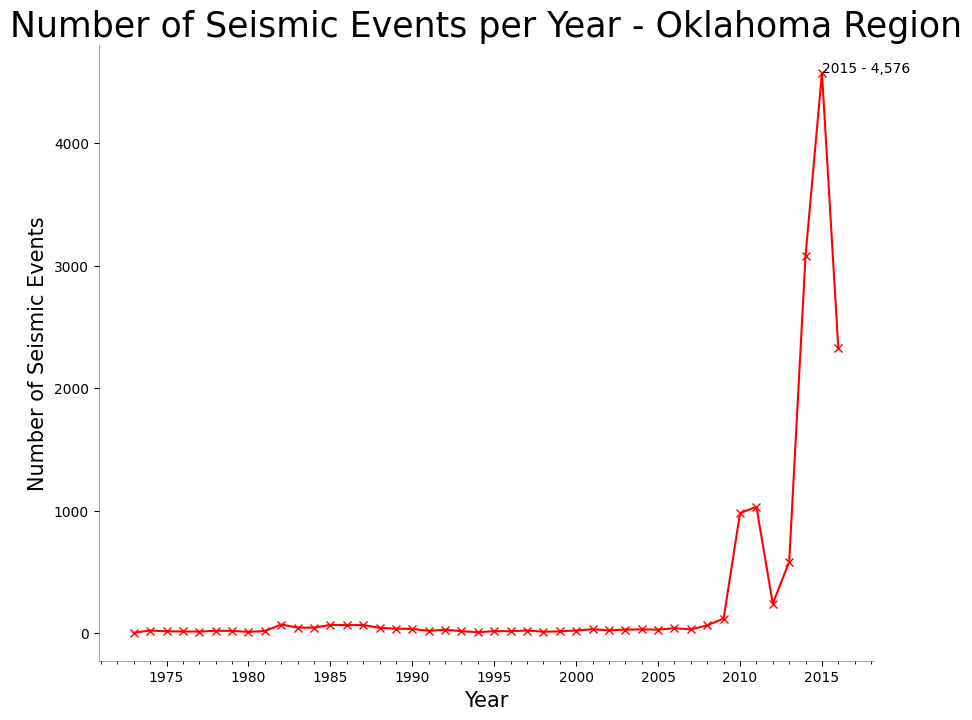

In [ ]:
# Line chart to show Number of Seismic Events per Year in the Oklahoma Region

ok_yearly_counts = updated_ok_quakes_df.groupby('year').size()

plt.figure(figsize =(10,8))

ok_yearly_counts.plot(kind= "line", 
                   marker= "x",
                   color = "red")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator())

ax.set_xlabel("Year",
              fontsize = 15)
ax.set_ylabel("Number of Seismic Events",
              fontsize = 15)
ax.set_title('Number of Seismic Events per Year - Oklahoma Region',
             fontsize = 25)

highest_index = ok_yearly_counts.idxmax()
x_coord = highest_index
y_coord = ok_yearly_counts.loc[highest_index]
plt.text(x_coord,
         y_coord,
         '2015 - 4,576')

plt.savefig("../plots/NumberOfSeismicEventsPerYear_OKRegion.png")
plt.show()

#### Depth and Magnitude for earthquakes in the Oklahoma Region from 2013 - 2016.

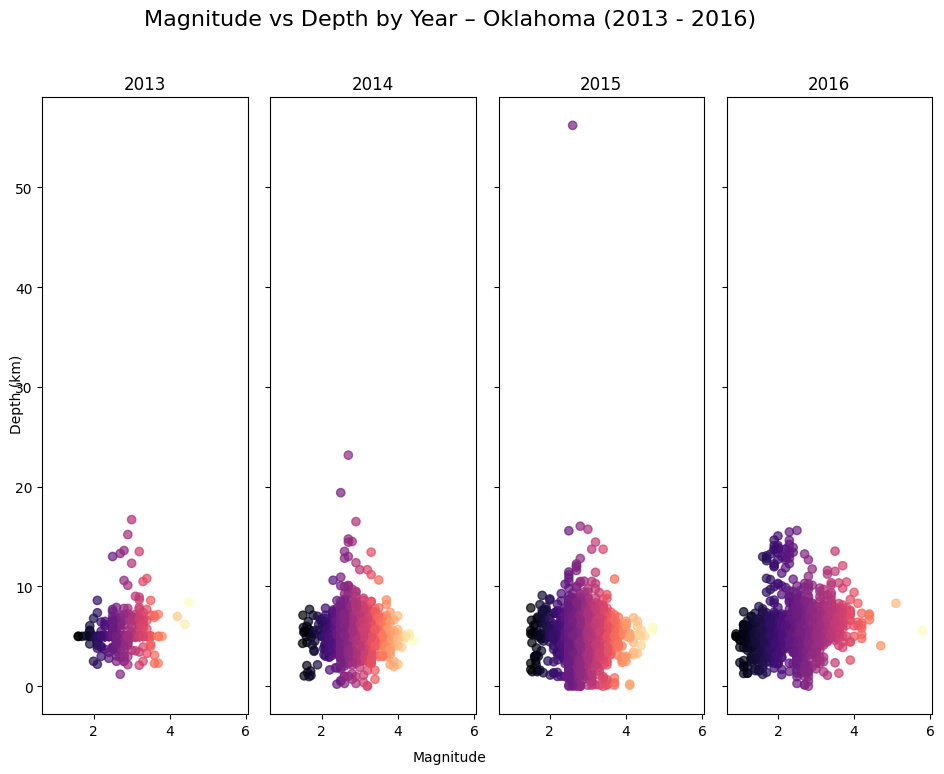

In [412]:
# Plot for showing magnitude and depth for each individual year from 2013 - 2016
start_year = 2013
end_year = 2017

df = updated_ok_quakes_df[
    (updated_ok_quakes_df['year'] >= start_year) &
    (updated_ok_quakes_df['year'] <= end_year) &
    (updated_ok_quakes_df['state'] == 'Oklahoma')
]

years = sorted(df['year'].unique())
n = len(years)

# determine subplot grid
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, year in zip(axes, years):
    year_data = df[df['year'] == year]

    sc = ax.scatter(
        year_data['magnitude'],
        year_data['depth'],
        c=year_data['magnitude'],
        cmap='magma',
        alpha=0.7
    )

    ax.set_title(f"{year}")
   

for ax in axes[n:]:
    ax.axis("off")

fig.suptitle(f"Magnitude vs Depth by Year – Oklahoma (2013 - 2016)",
             fontsize=16)

fig.text(0.5, 0.04, 'Magnitude', ha='center')
fig.text(0.06, 0.5, 'Depth (km)', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
plt.savefig('../plots/OkEarthquakesMagnitudeDepthByYear.png')
plt.show()


This chart shows a consistent number of seismic events between a magnitude of 2 and 4. Also an average depth between 0 and 10 km.  However, it also shows how the events have increased from year to year.